# Mini Project 5

Welcome to the last Mini Project! In this assignment, you will implement autoencoders (AEs) and generative adversarial networks (GANs) based on the relevant concepts learned in the class.

---
**Requirements**: 
- Your code should follow [PEP 8](https://www.python.org/dev/peps/pep-0008/) with necessary comments.

In [ ]:
# libraries
from google.colab import drive
import torch
import torchvision.datasets as datasets
from torchvision import transforms
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
from torch.autograd import Variable
import pandas as pd
from PIL import Image
from torchvision.utils import make_grid
!pip install torchviz
from torchviz import make_dot

# settings
drive.mount("/content/drive") # mount the drive
path = "/content/drive/My Drive/Coursework/Deep Learning/Mini Project 05/" # path to dataset directory
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # set device

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4147 sha256=dee48e640ef9fc5c9aae2ad4056be7003538cff2e7b69a3416edef5e024e195e
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz
Mounted at /content/drive


## Task 1: Autoencoders vs. Principal Components Analysis
Principal components analysis (PCA) is a common used method for dimensionality reduction. It's an unsupervised technique that reduces the dimensionality of the data by **orthogonally transforming** the data into a set of principal components. The first principal component explains the most amount of the variation in the data in a single component, the second component explains the second most amount of the variation, etc. By choosing the top principal components that explain say 80-90% of the variation, the other components can be dropped since they do not significantly benefit the model.

Autoencoder is another unsupervised technique can be used for dimensionality reduction in which we leverage neural networks for the task of representation learning. Specifically, a **bottleneck** will be imposed in the network which forces a compressed knowledge representation of the original input.

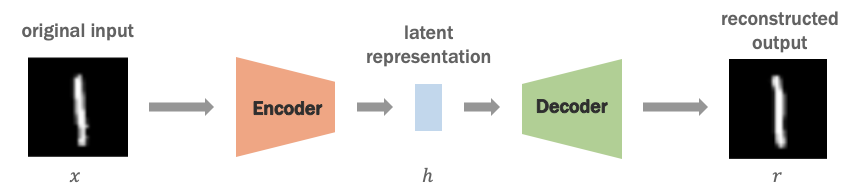


**Tasks**

In this task, you will build two models for dimensionality reduction based on PCA and Autoencoder, respectively. You will use the developed models on the handwritten digits and compare the performance. **The reduced dimension should be two so that the visualization is convenient.**

1. Load [MNIST](https://www.datascienceweekly.org/tutorials/pytorch-mnist-load-mnist-dataset-from-pytorch-torchvision) dataset and preprocess the dataset.
2. Design a PCA model for dimensionality reduction. Please check [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) for more information.
3. Implement an Autoencoder based on Pytorch.
4. Compare the reconstruction losses (MSE) of PCA and Autoencoder on the test data.
5. Visualize the reduced results of PCA and Autoencoder.
6. Analyse the pros and cons of each model.

1. Load [MNIST](https://www.datascienceweekly.org/tutorials/pytorch-mnist-load-mnist-dataset-from-pytorch-torchvision) dataset and preprocess the dataset.

In [ ]:
transform = transforms.ToTensor() # transform images to tensors

mnist_trainset = datasets.MNIST(root=path, train=True,
                                download=True, transform=transform) # load train set
mnist_testset = datasets.MNIST(root=path, train=False,
                               download=True, transform=transform) # load test set

m = len(mnist_trainset) # training set size
train_data, valid_data = random_split(mnist_trainset, [int(m-m*0.2), int(m*0.2)]) # train & valid sets
test_data = mnist_testset # test set
batch_size = 256 # batch size

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size) # train data loader
valid_loader = torch.utils.data.DataLoader(valid_data,
                                           batch_size=batch_size) # valid data loader
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          shuffle=True) # test data loader

print('Train Set Size : ', len(train_data)) # print train set size
print('Valid Set Size : ', len(valid_data)) # print train set size
print('Test Set Size  : ', len(test_data)) # print test set size

Train Set Size :  48000
Valid Set Size :  12000
Test Set Size  :  10000


In [ ]:
array_trainset = mnist_trainset.data.numpy() # convert train set to numpy array
array_trainset = array_trainset.reshape(array_trainset.shape[0],
                                        array_trainset.shape[1]*array_trainset.shape[2]) # reshape to 2D
array_trainset = array_trainset.astype(np.float32)/255.0
array_testset = mnist_testset.data.numpy() # convert test set to numpy array
array_testset = array_testset.reshape(array_testset.shape[0],
                                      array_testset.shape[1]*array_testset.shape[2]) # reshape to 2D
array_testset = array_testset.astype(np.float32)/255.0
print('Train Set Shape : ', array_trainset.shape) # print train set shape
print('Test Set Shape  : ', array_testset.shape) # print test set shape

Train Set Shape :  (60000, 784)
Test Set Shape  :  (10000, 784)


2. Design a PCA model for dimensionality reduction. Please check [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) for more information.

In [ ]:
# design and fit PCA model
pca_model = PCA(n_components=2) # define PCA model with reduced dimension = 2
components = pca_model.fit_transform(array_trainset) # extract principal components (PCs)

In [ ]:
# compute reconstruction error on train set
mu = array_trainset.mean(axis=0) # mean computation
U,S,V = np.linalg.svd(array_trainset - mu, full_matrices=False) # SVD
z_pca = np.dot(array_trainset - mu, V.transpose()) # latent space representation (z)
r_pca = np.dot(z_pca[:,:2], V[:2,:]) + mu # reconstruction to original representation (r)
pca_mse = np.sum((array_trainset-r_pca)**2)/r_pca.shape[0]/r_pca.shape[1] # MSE computation
print('Train Set Reconstruction MSE (PCA): ' + str(round(pca_mse, 3))); # print MSE

Train Set Reconstruction MSE (PCA): 0.056


In [ ]:
# compute reconstruction error on test set
mu = array_testset.mean(axis=0) # mean computation
U,S,V = np.linalg.svd(array_testset - mu, full_matrices=False) # SVD
z_pca = np.dot(array_testset - mu, V.transpose()) # latent space representation (z)
r_pca = np.dot(z_pca[:,:2], V[:2,:]) + mu # reconstruction to original representation (r)
pca_mse = np.sum((array_testset-r_pca)**2)/r_pca.shape[0]/r_pca.shape[1] # MSE computation
print('Test Set Reconstruction MSE (PCA): ' + str(round(pca_mse, 3))); # print MSE

Test Set Reconstruction MSE (PCA): 0.056


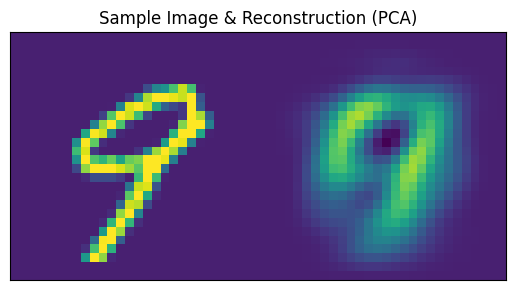

In [ ]:
# reconstruct (random) image from principal components
index = np.random.randint(0, components.shape[0]-1) # generate random index
original = array_testset[index].reshape(28, 28) # original image
reconstruction = pca_model.inverse_transform(components[index]) # reverse PCA for reconstruction
reconstruction = reconstruction.reshape(28, 28) # reshape reconstructed image
result = np.hstack((original, reconstruction)) # stack original and reconstructed images
plt.grid(False) # hide grid
plt.tick_params(left=False, right=False, bottom=False,
                labelleft = False, labelbottom=False) # hide ticks and labels
plt.title('Sample Image & Reconstruction (PCA)') # add title
plt.imshow(result); # show reconstructed image

3. Implement an Autoencoder based on Pytorch.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        # convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1), # conv 1
            nn.BatchNorm2d(8), # batch normalization
            nn.ReLU(True), # relu activation
            nn.Conv2d(8, 16, 3, stride=2, padding=1), # conv 2
            nn.BatchNorm2d(16), # batch normalization
            nn.ReLU(True), # relu activation
            nn.Conv2d(16, 32, 3, stride=2, padding=0), # conv 3
            nn.ReLU(True) # relu activation
        )
        # flatten layer
        self.flatten = nn.Flatten(start_dim=1) # flatten
        # linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128), # linear 1
            nn.ReLU(True), # relu activation
            nn.Linear(128, encoded_space_dim) # linear 2
        )
    def forward(self, x):
        x = self.encoder_cnn(x) # convolutional section
        x = self.flatten(x) # flatten layer
        x = self.encoder_lin(x) # linear section
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        # linear section
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128), # linear 1
            nn.ReLU(True), # relu activation
            nn.Linear(128, 3 * 3 * 32), # linear 2
            nn.ReLU(True) # relu activation
        )
        # unflatten layer
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)) # unflatten
        # deconvolutional section
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0), # deconv 1
            nn.BatchNorm2d(16), # batch normalization
            nn.ReLU(True), # relu activation
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1), # deconv 2
            nn.BatchNorm2d(8), # batch normalization
            nn.ReLU(True), # relu activation
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1) # deconv 3
        )
    def forward(self, x):
        x = self.decoder_lin(x) # linear section
        x = self.unflatten(x) # unflatten layer
        x = self.decoder_conv(x) # deconvolutional section
        x = torch.sigmoid(x) # sigmoid activation
        return x

In [ ]:
torch.manual_seed(0) # random seed for reproducible results
loss_fn = torch.nn.MSELoss() # loss function
learning_rate = 0.001 # learning rate
latent_dim = 2 # latent space dimenstion
encoder = Encoder(encoded_space_dim=latent_dim) # instantiate encoder
decoder = Decoder(encoded_space_dim=latent_dim) # instantiate decoder
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
] # optimization parameters
optim = torch.optim.Adam(params_to_optimize,
                         lr=learning_rate,
                         weight_decay=1e-05) # optimizer
encoder.to(device) # move encoder to selected device
decoder.to(device) # move decoder to selected device
print(encoder) # print encoder
print(decoder) # print decoder

Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (7): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)
Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflatte

In [ ]:
for image_batch, _ in train_loader: # with "_" just ignore the labels
    image_batch = image_batch.to(device) # move tensor to the selected device
# encode data
y_hat = encoder(image_batch)
# decode data
x_hat = decoder(y_hat)

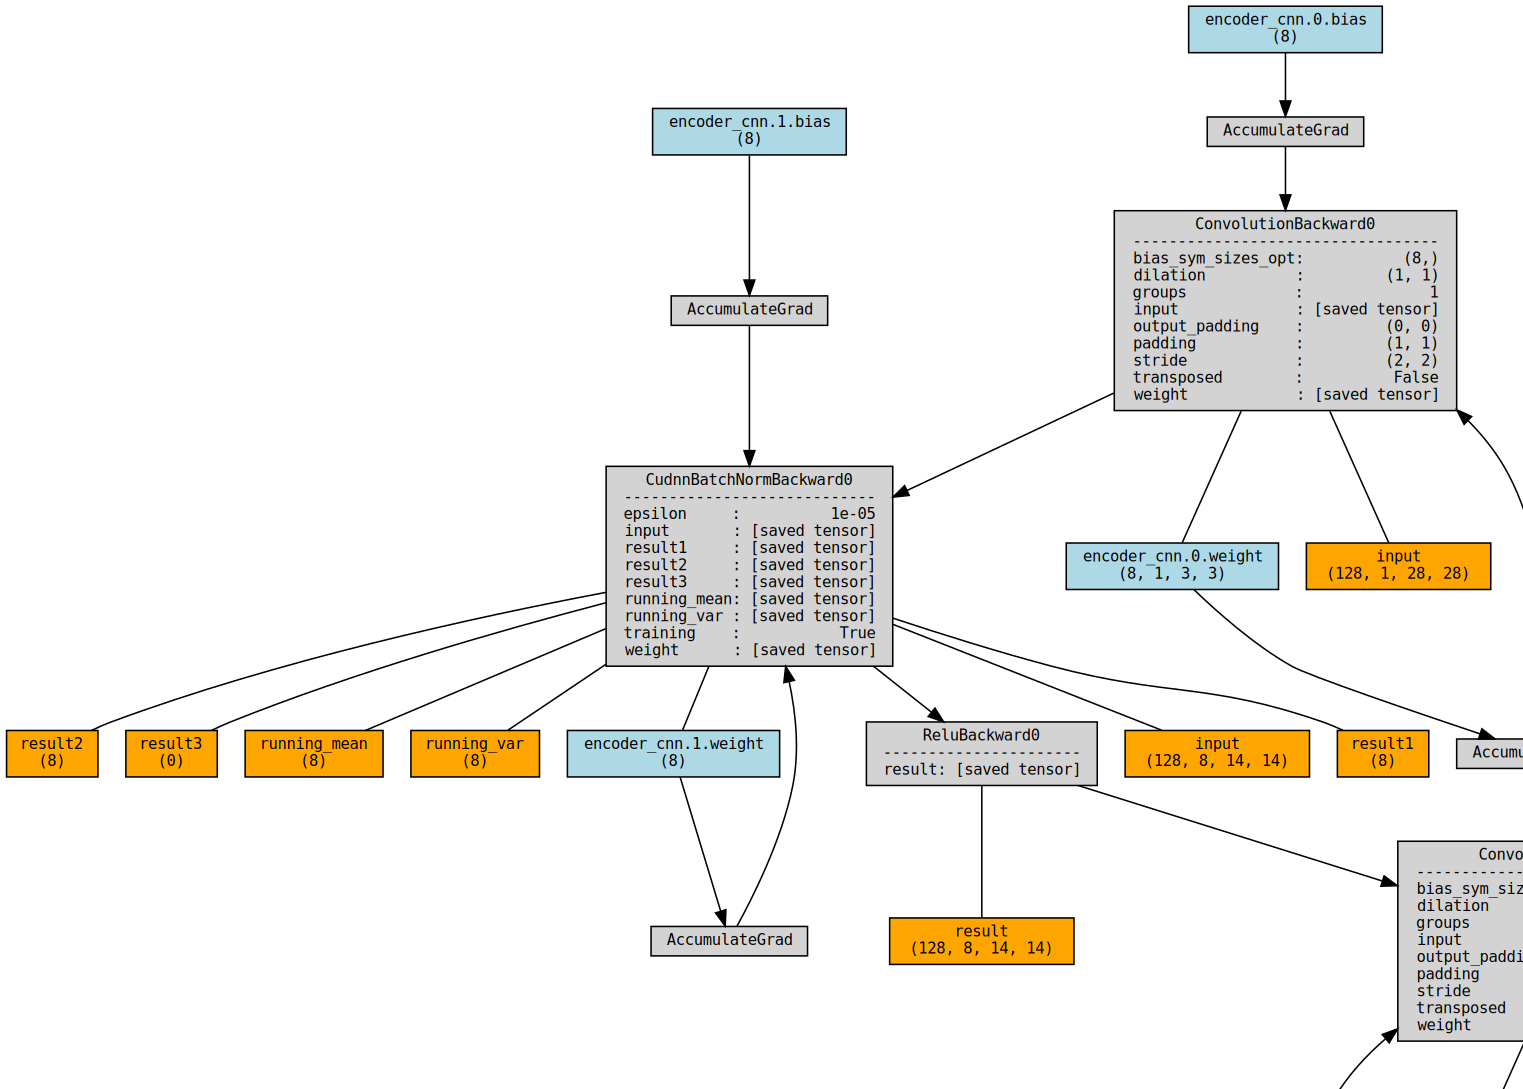

In [ ]:
encoder_dot = make_dot(y_hat, params=dict(encoder.named_parameters()), show_attrs=True, show_saved=True) # create encoder visualization
encoder_dot.format = "pdf" # model visualization saving format
encoder_dot.render(path + "Task1_Encoder") # save model visualization
encoder_dot # visualize model

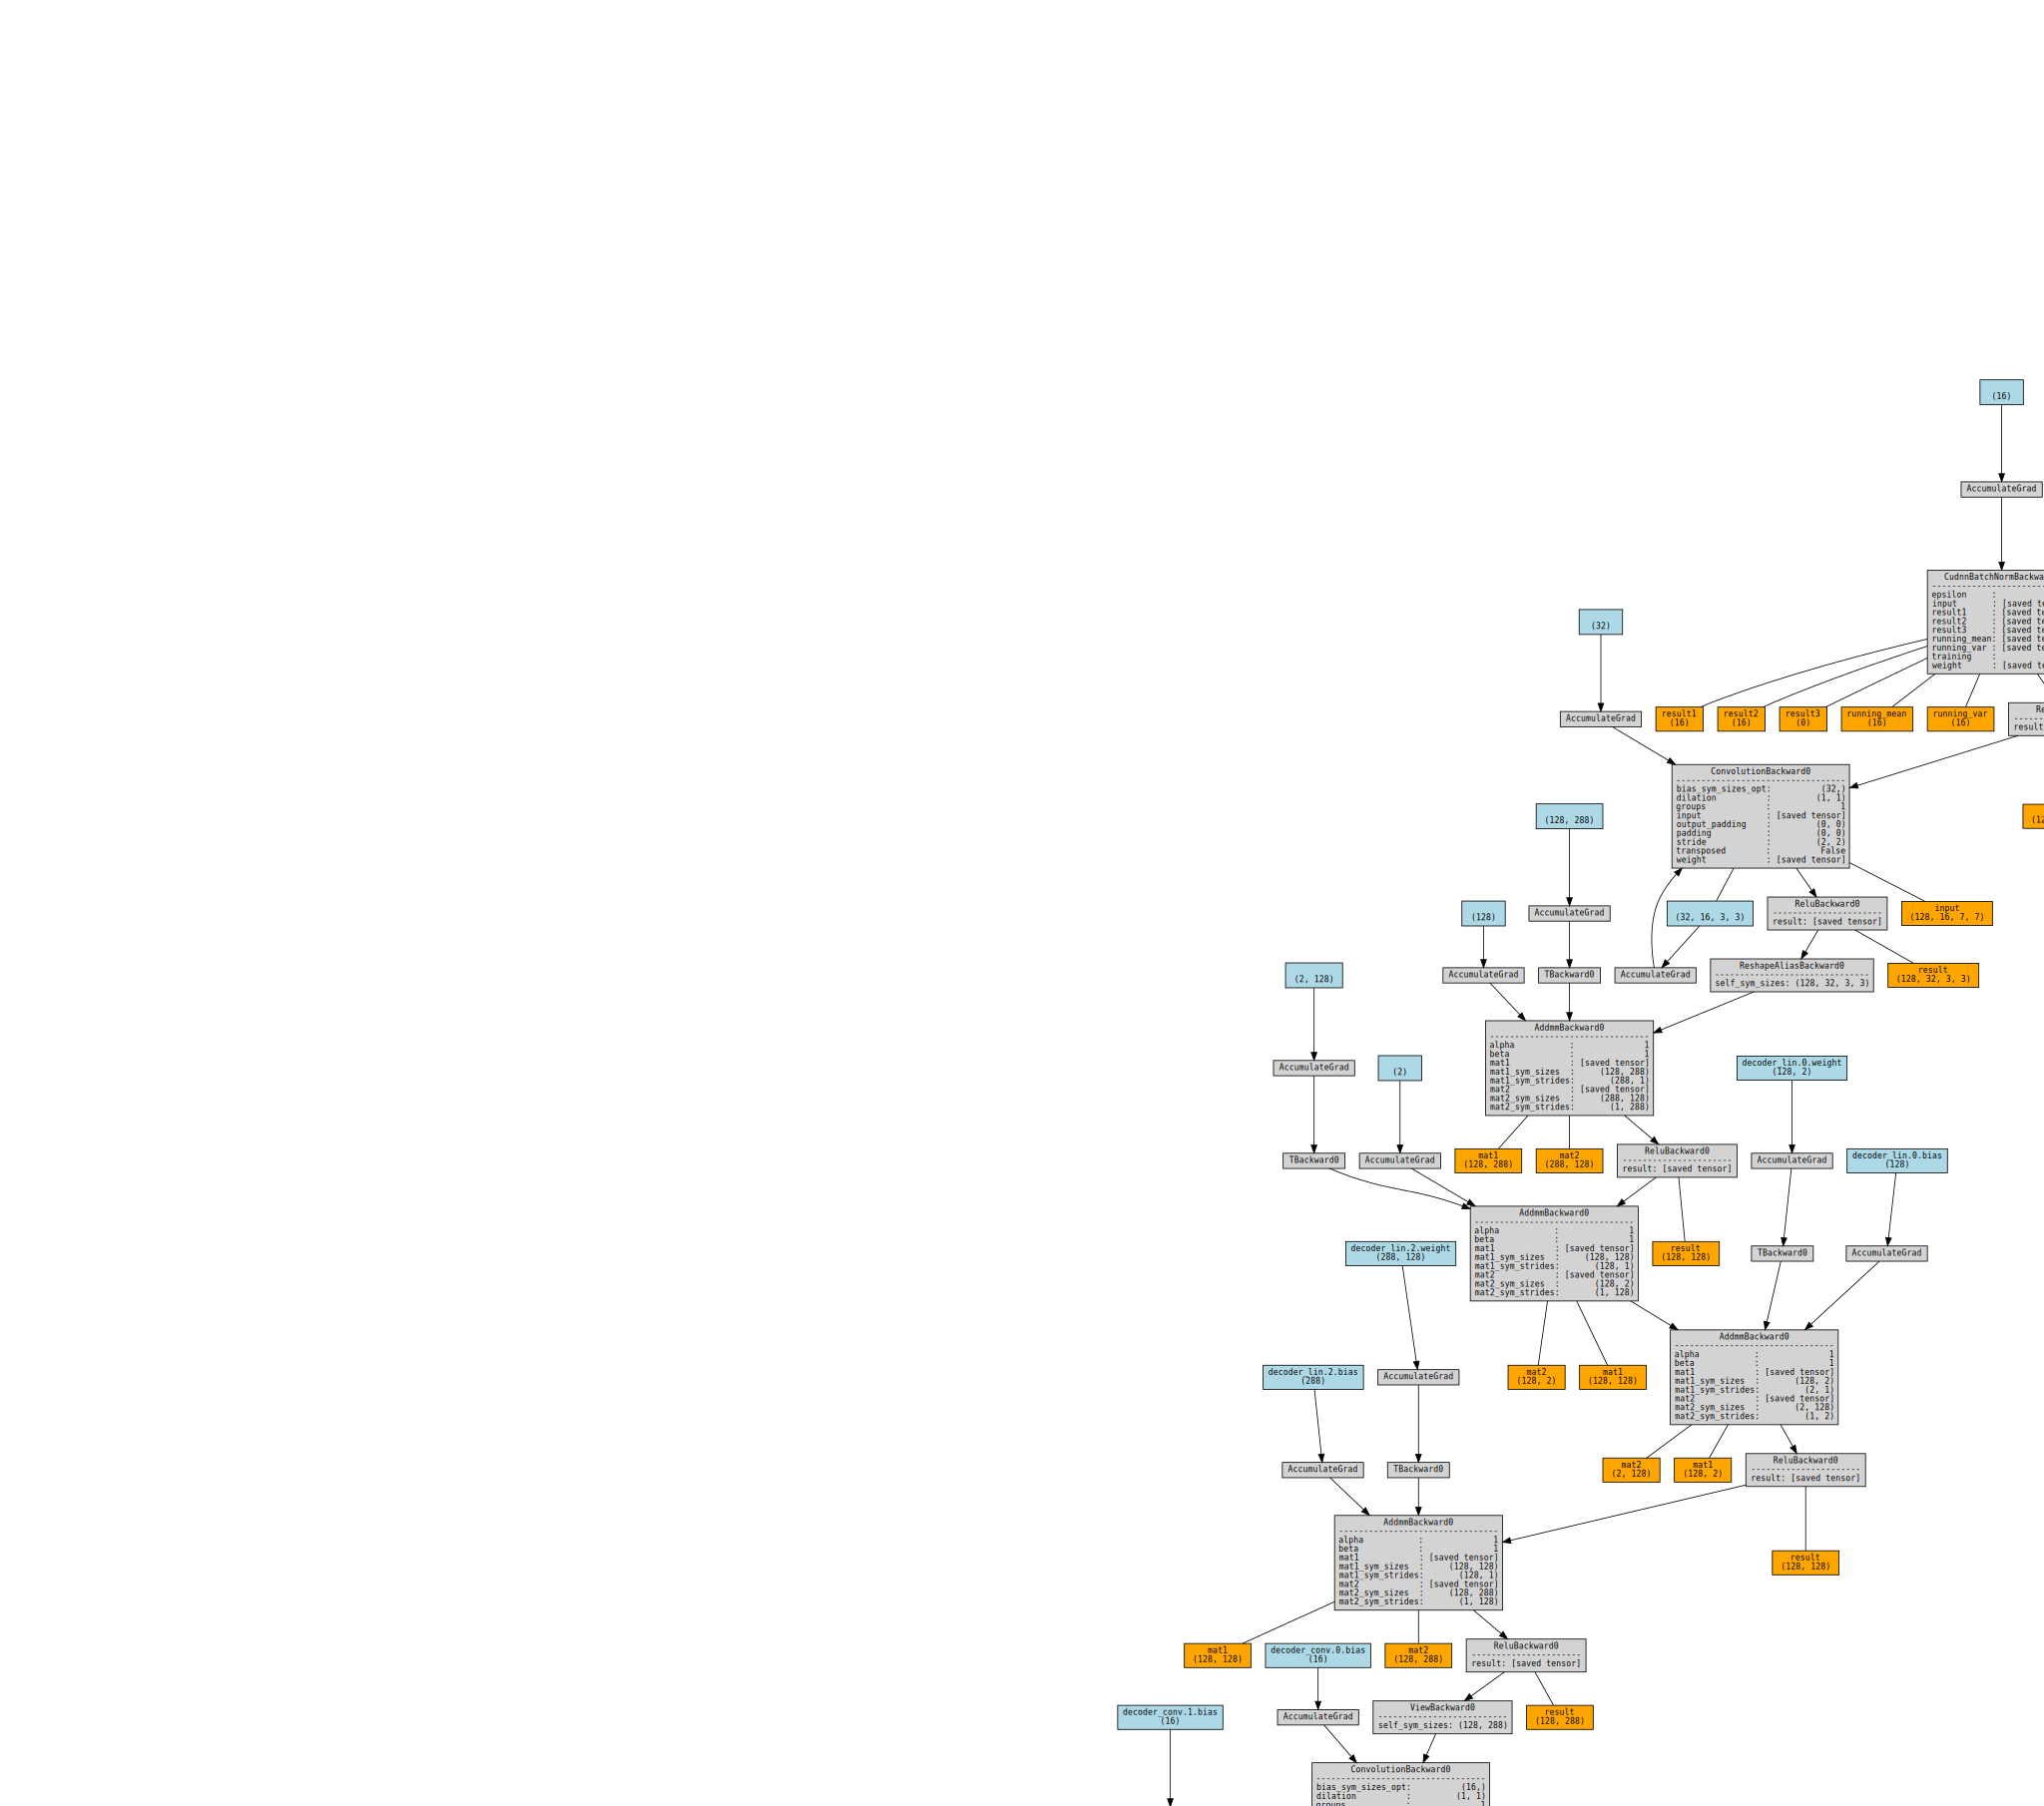

In [ ]:
decoder_dot = make_dot(x_hat, params=dict(decoder.named_parameters()), show_attrs=True, show_saved=True) # create decoder visualization
decoder_dot.format = "pdf" # model visualization saving format
decoder_dot.render(path + "Task1_Decoder") # save model visualization
decoder_dot # visualize model

In [ ]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    encoder.train() # set encoder to training mode
    decoder.train() # set decoder to training mode
    train_loss = [] # list of loss history
    # iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" just ignore the labels
        # move tensor to the selected device
        image_batch = image_batch.to(device)
        # encode data
        encoded_data = encoder(image_batch)
        # decode data
        decoded_data = decoder(encoded_data)
        # evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # parameter update
        optimizer.step()
        # append loss
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

In [ ]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    encoder.eval() # set encoder to evaluation mode
    decoder.eval() # set encoder to evaluation mode
    with torch.no_grad(): # no need to track the gradients in evaluation mode
        originals = [] # list to store original inputs for each batch
        reconstructions = [] # list to store reconstructed outputs for each batch        
        for image_batch, _ in dataloader:
            # move tensor to the selected device
            image_batch = image_batch.to(device)
            # encode data
            encoded_data = encoder(image_batch)
            # decode data
            decoded_data = decoder(encoded_data)
            # append inputs and outputs
            originals.append(image_batch.cpu()) # append original images
            reconstructions.append(decoded_data.cpu()) # append reconstructions
        # create a single tensor with all the values in the lists
        reconstructions = torch.cat(reconstructions)
        originals = torch.cat(originals) 
        # evaluate loss
        test_loss = loss_fn(reconstructions, originals)
    return test_loss.data

In [ ]:
def plot_outputs(encoder, decoder, n=10):
    plt.figure(figsize=(16, 4.5)) # figure size
    targets = mnist_testset.targets.numpy() # extract labels
    idx = {i:np.where(targets==i)[0][0] for i in range(n)} # extract indices of n labels
    for i in range(n): # fon n number of images
        img = mnist_testset[idx[i]][0].unsqueeze(0).to(device) # original image
        encoder.eval() # set encoder to evaluation mode
        decoder.eval() # set encoder to evaluation mode
        with torch.no_grad(): # no need to track the gradients in evaluation mode
            rec_img  = decoder(encoder(img)) # reconstructed image
        # plot original and reconstructed images
        ax = plt.subplot(2, n, i+1) # first subplot
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray') # plot original images
        ax.get_xaxis().set_visible(False) # invisible x axis
        ax.get_yaxis().set_visible(False) # invisible y axis
        if i == n//2:
            ax.set_title('Original Images') # subplot title
        ax = plt.subplot(2, n, i + 1 + n) # second subplot
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray') # plot reconstructions
        ax.get_xaxis().set_visible(False) # invisible x axis
        ax.get_yaxis().set_visible(False) # invisible y axis 
        if i == n//2:
            ax.set_title('Reconstructed Images') # subplot title
    plt.show() # show plot

Started Training!


Epoch: 1    Train Loss: 0.1015    Test Loss: 0.0614


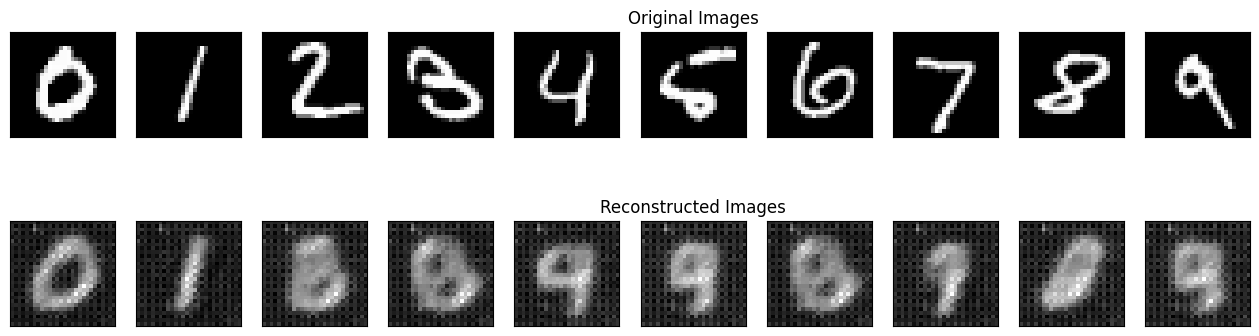

Epoch: 2    Train Loss: 0.0522    Test Loss: 0.0472


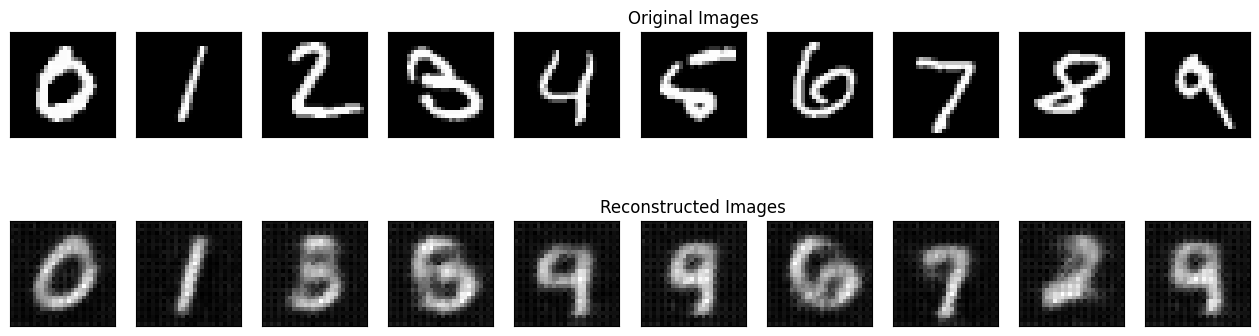

Epoch: 3    Train Loss: 0.0451    Test Loss: 0.0440


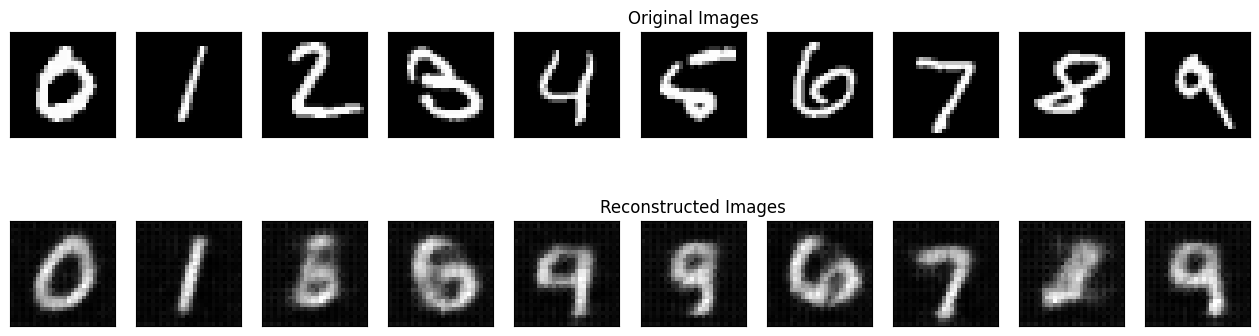

Epoch: 4    Train Loss: 0.0428    Test Loss: 0.0424


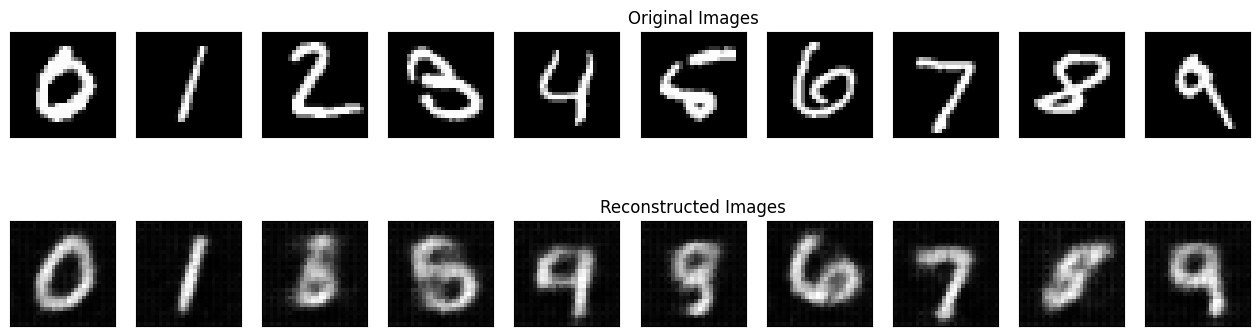

Epoch: 5    Train Loss: 0.0416    Test Loss: 0.0414


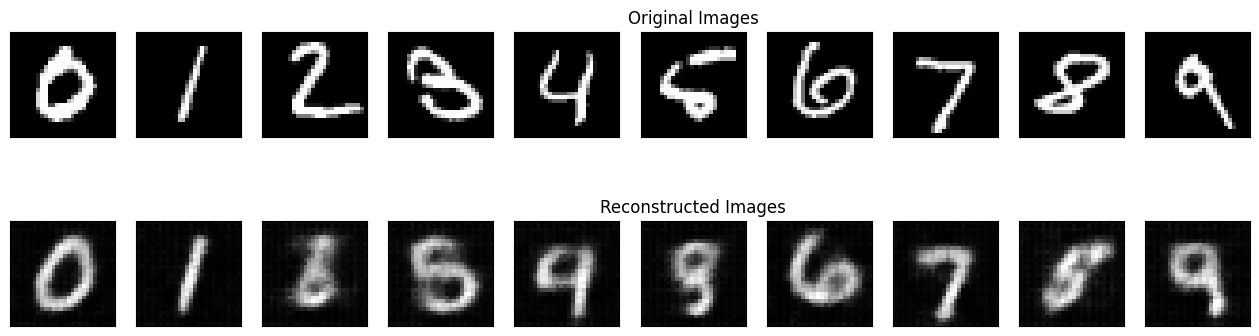

Epoch: 6    Train Loss: 0.0407    Test Loss: 0.0408


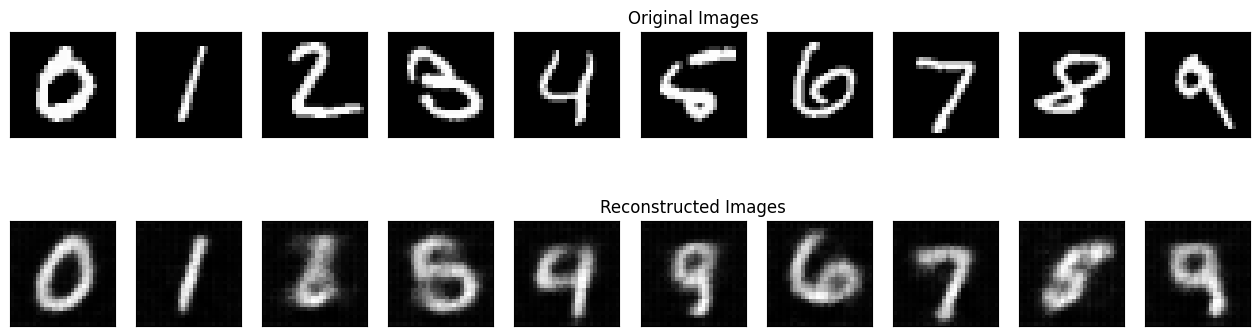

Epoch: 7    Train Loss: 0.0401    Test Loss: 0.0403


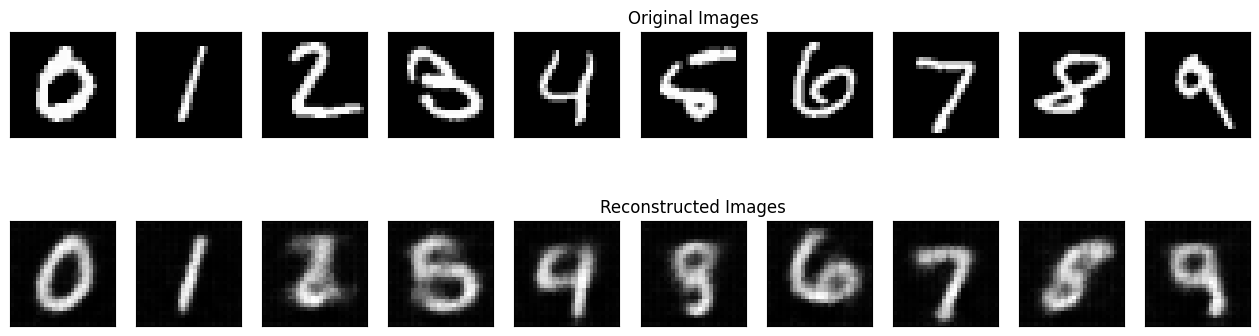

Epoch: 8    Train Loss: 0.0397    Test Loss: 0.0398


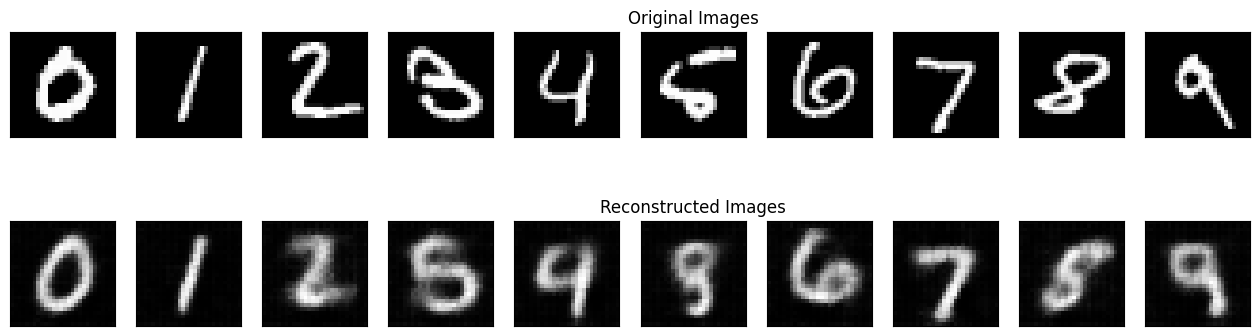

Epoch: 9    Train Loss: 0.0393    Test Loss: 0.0396


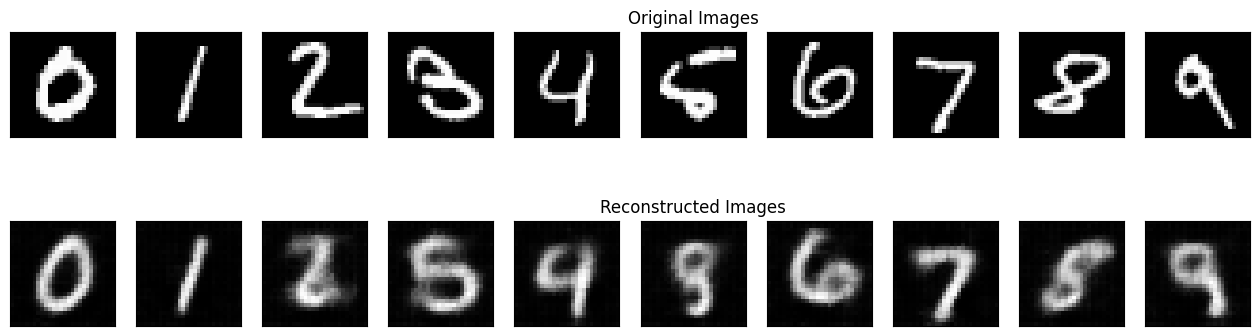

Epoch: 10    Train Loss: 0.0390    Test Loss: 0.0393


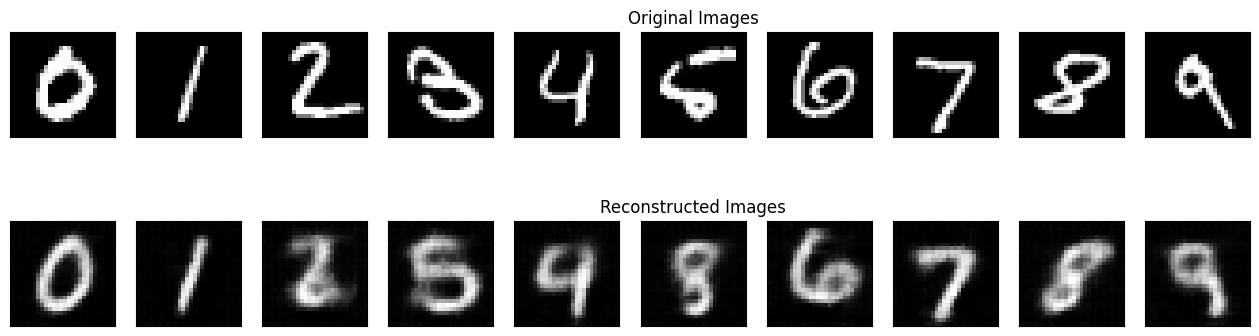

Epoch: 11    Train Loss: 0.0388    Test Loss: 0.0391


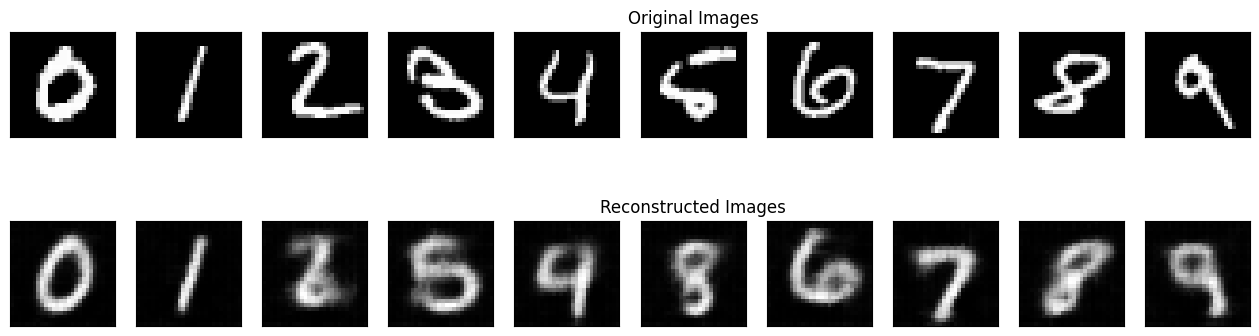

Epoch: 12    Train Loss: 0.0385    Test Loss: 0.0389


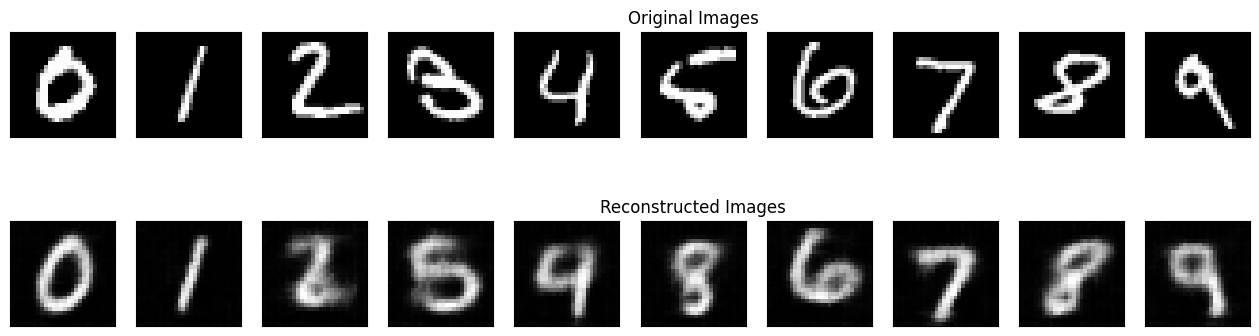

Epoch: 13    Train Loss: 0.0383    Test Loss: 0.0388


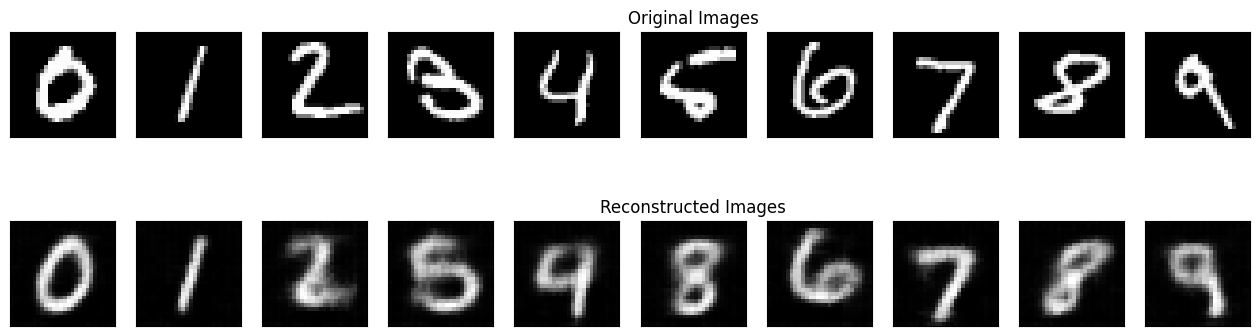

Epoch: 14    Train Loss: 0.0381    Test Loss: 0.0386


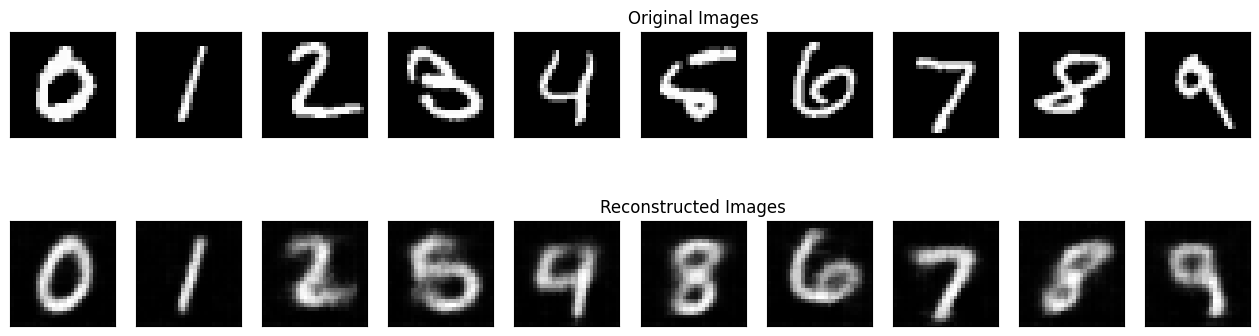

Epoch: 15    Train Loss: 0.0380    Test Loss: 0.0385


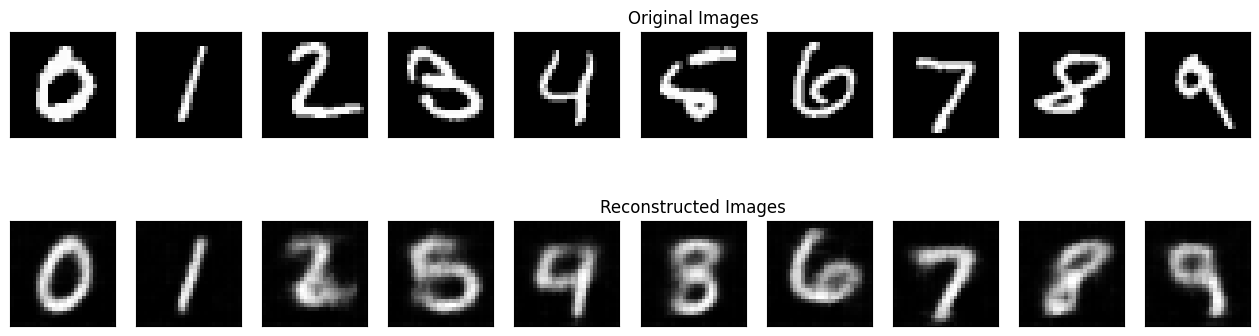

Epoch: 16    Train Loss: 0.0379    Test Loss: 0.0384


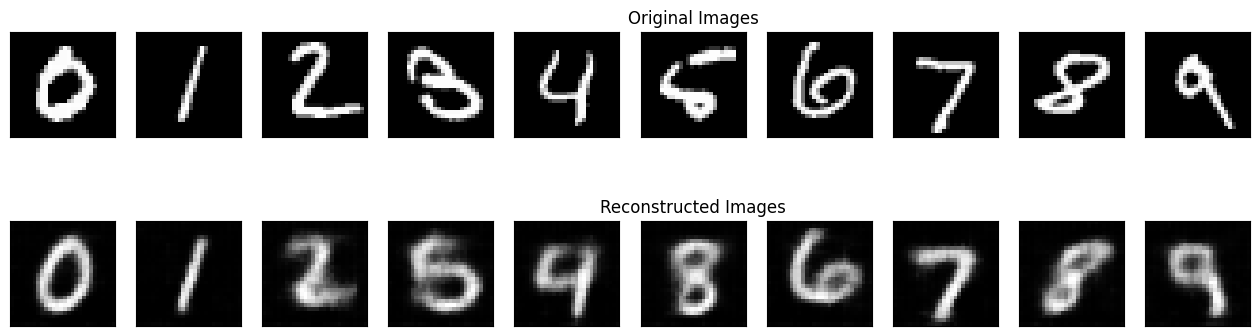

Epoch: 17    Train Loss: 0.0377    Test Loss: 0.0383


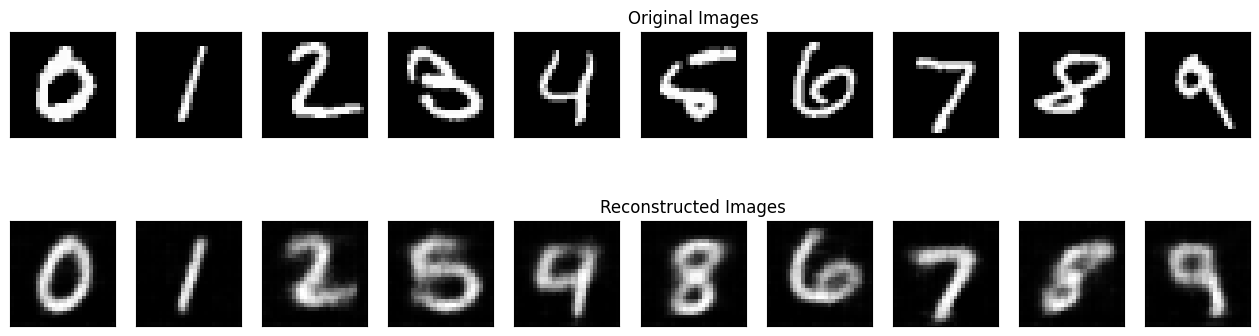

Epoch: 18    Train Loss: 0.0376    Test Loss: 0.0382


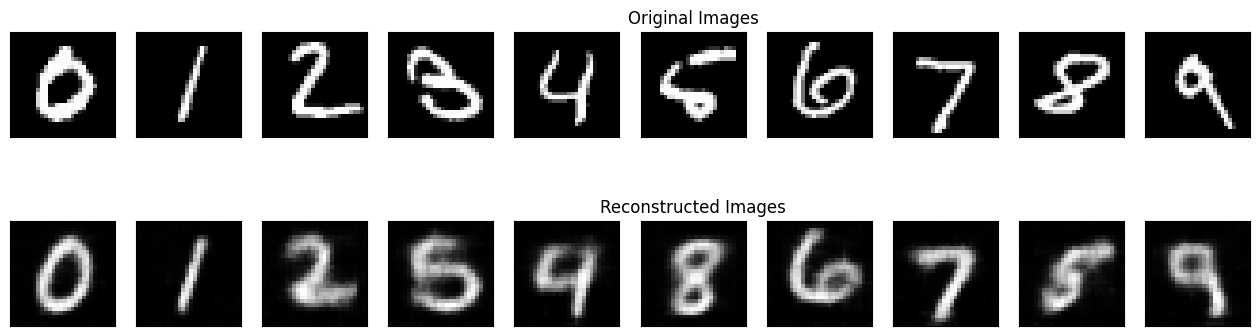

Epoch: 19    Train Loss: 0.0375    Test Loss: 0.0382


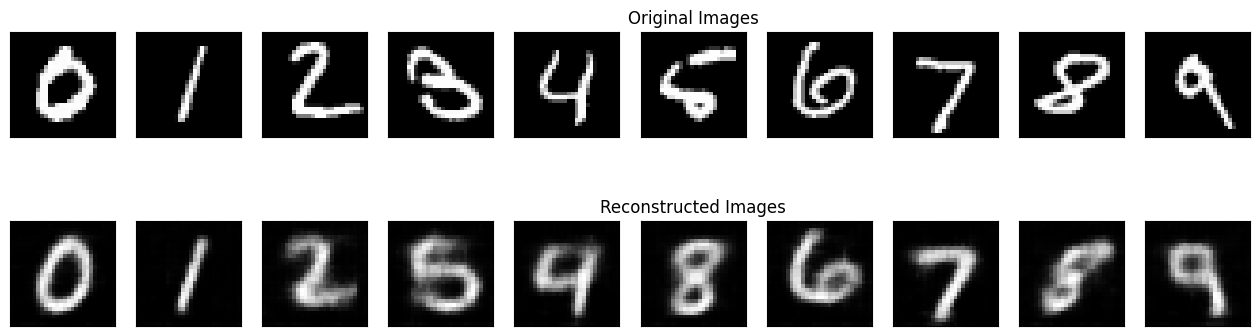

Epoch: 20    Train Loss: 0.0374    Test Loss: 0.0381


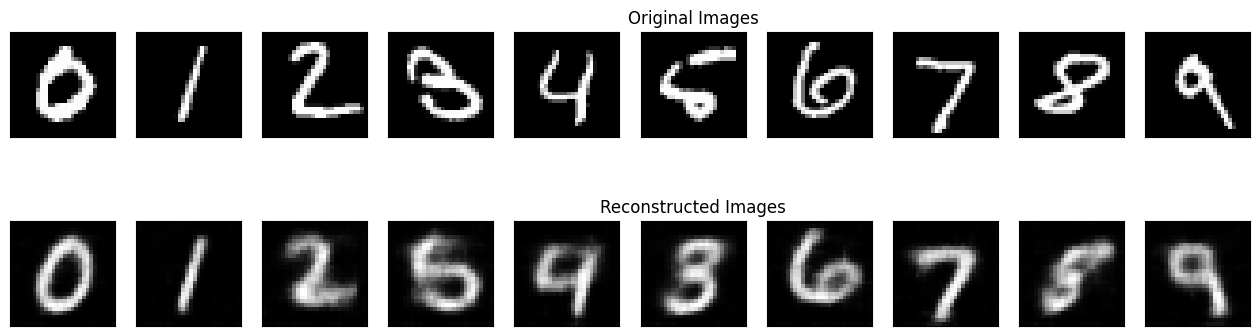

Epoch: 21    Train Loss: 0.0373    Test Loss: 0.0382


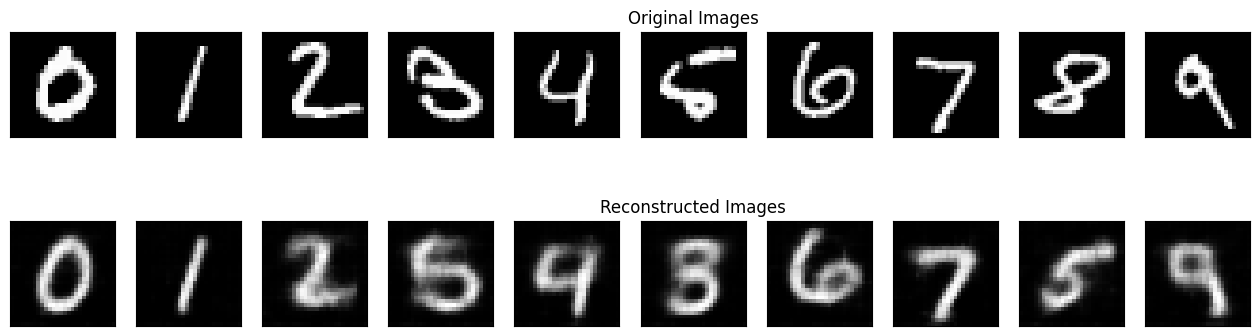

Epoch: 22    Train Loss: 0.0372    Test Loss: 0.0380


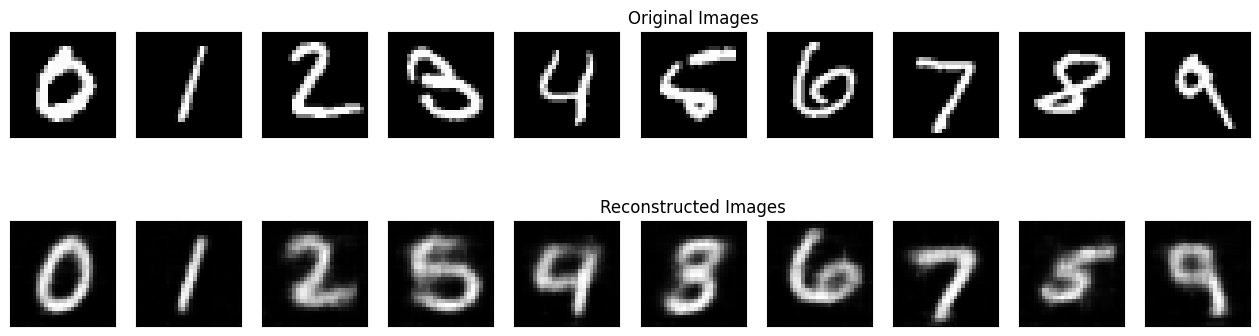

Epoch: 23    Train Loss: 0.0372    Test Loss: 0.0380


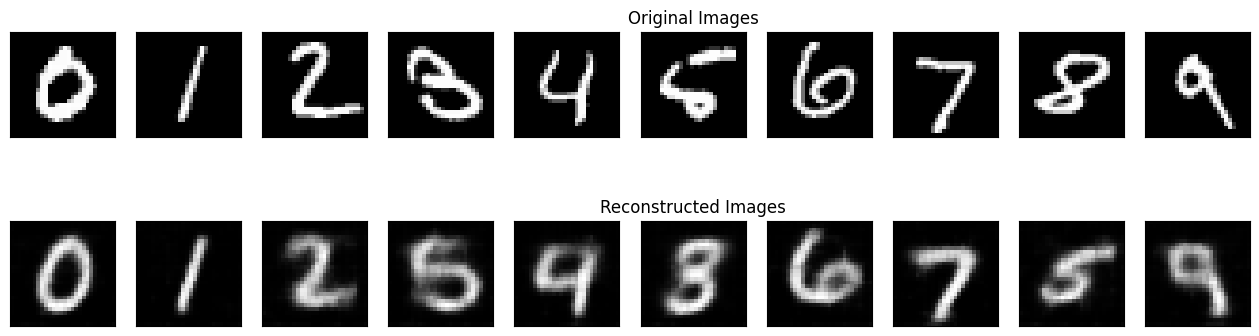

Epoch: 24    Train Loss: 0.0371    Test Loss: 0.0378


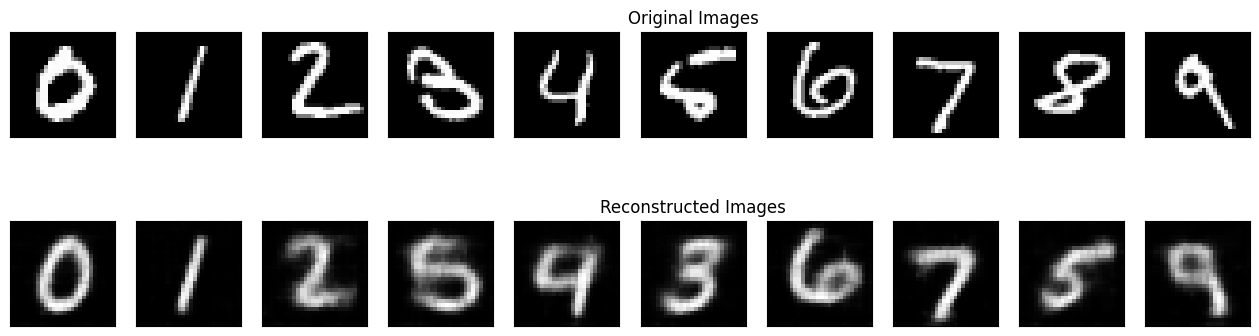

Epoch: 25    Train Loss: 0.0370    Test Loss: 0.0379


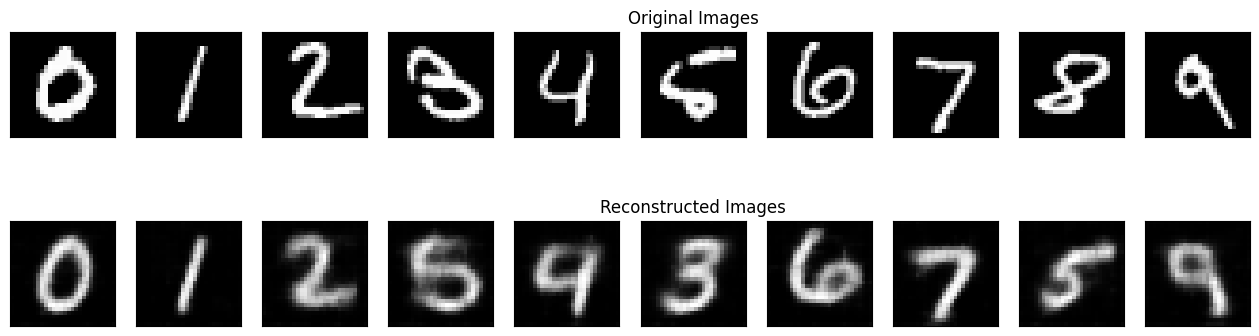

Epoch: 26    Train Loss: 0.0369    Test Loss: 0.0378


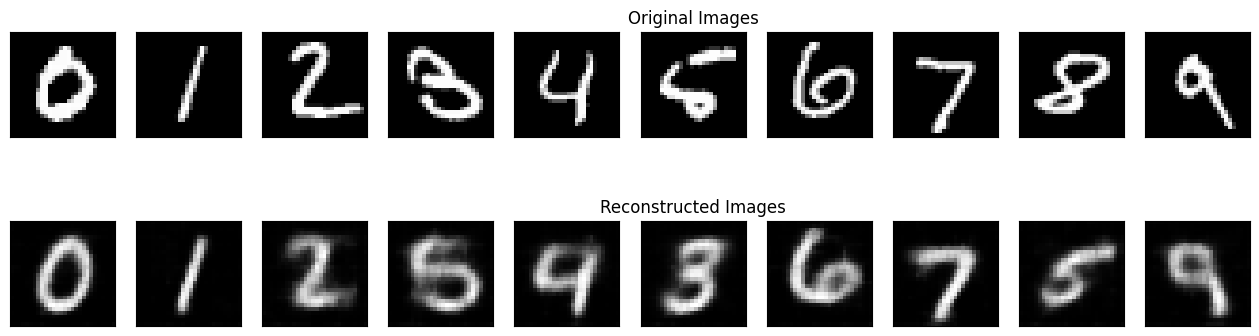

Epoch: 27    Train Loss: 0.0368    Test Loss: 0.0377


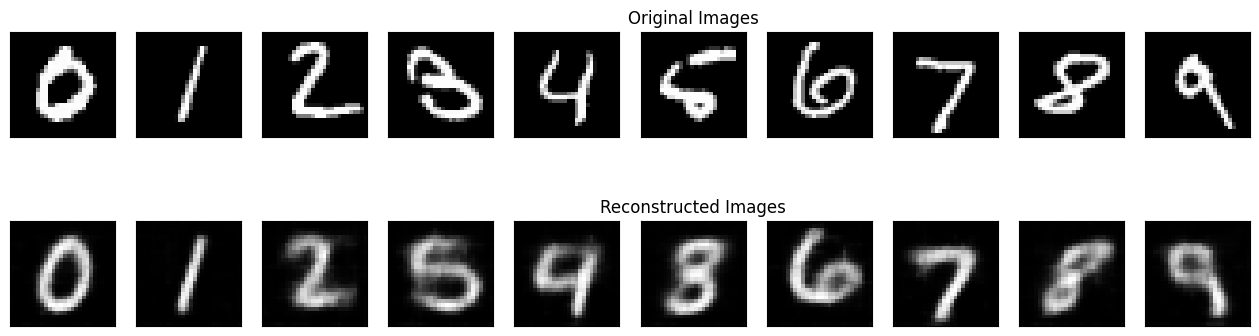

Epoch: 28    Train Loss: 0.0368    Test Loss: 0.0377


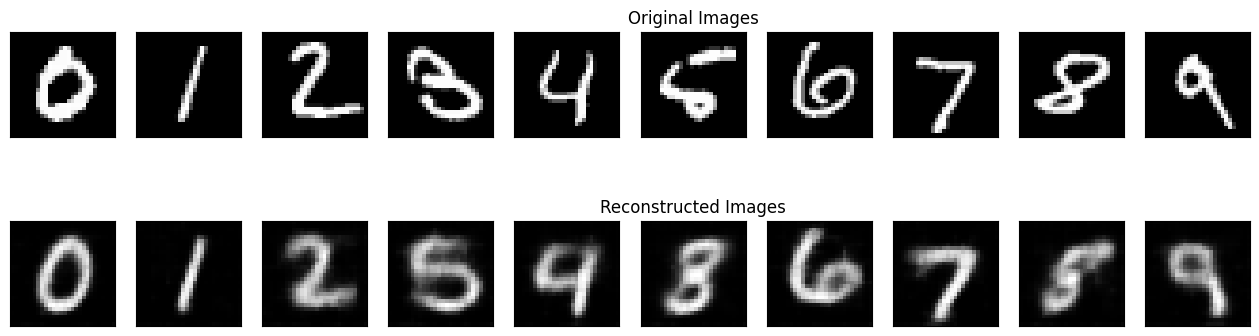

Epoch: 29    Train Loss: 0.0368    Test Loss: 0.0377


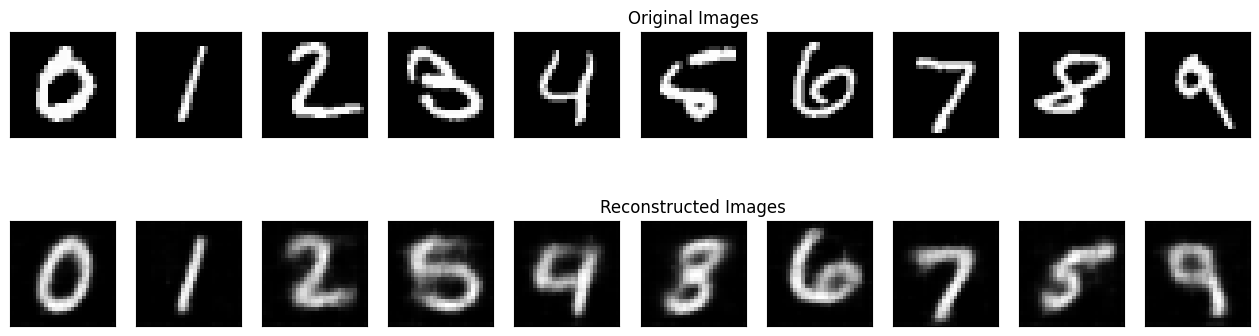

Epoch: 30    Train Loss: 0.0367    Test Loss: 0.0375


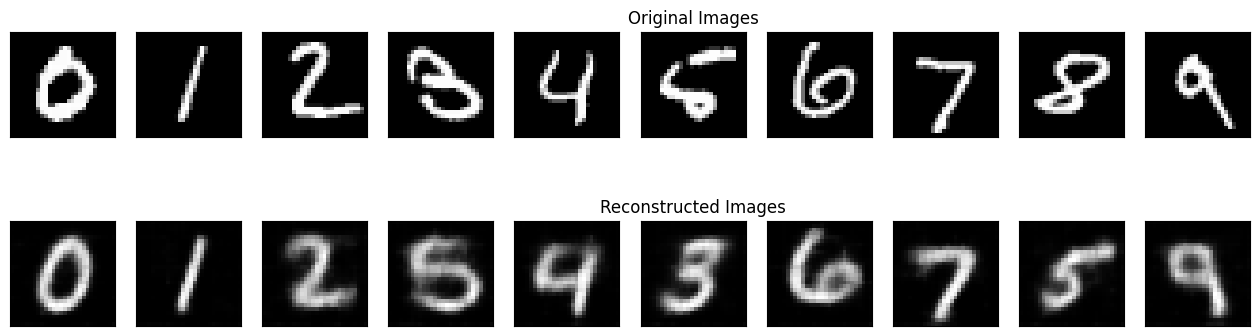



Finished Training!


In [ ]:
epochs = 30 # number of training epochs
losses = {'train_loss':[],'valid_loss':[]} # history of losses

print("Started Training!\n\n") # begin training

for epoch in range(epochs):
    train_loss = train_epoch(encoder, decoder, device, train_loader, loss_fn, optim) # train loss
    valid_loss = test_epoch(encoder, decoder, device, test_loader, loss_fn) # valid loss
    # print training & validation stats at end of each epoch
    print("Epoch: {}    Train Loss: {:.4f}    Test Loss: {:.4f}".format(
          epoch+1, train_loss, valid_loss)) # training log
    losses['train_loss'].append(train_loss) # append train loss
    losses['valid_loss'].append(valid_loss) # append valid loss
    plot_outputs(encoder, decoder, n=10) # plot outputs to analyse training

print("\n\nFinished Training!") # finish training

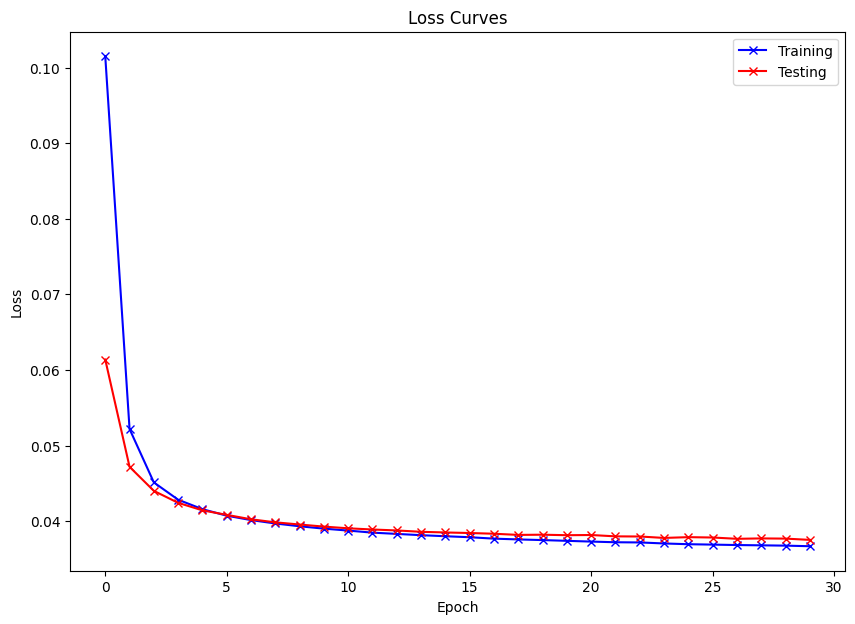

In [ ]:
# plot the loss history over all epochs
plt.figure(figsize=(10, 7))
plt.plot(losses['train_loss'], '-bx', label='Training') # plot training loss
plt.plot(losses['valid_loss'], '-rx', label='Testing') # plot testing loss
plt.xlabel('Epoch') # add label for x-axis
plt.ylabel('Loss') # add label for y-axis
plt.legend() # add legend
plt.title('Loss Curves') # title
plt.show() # show plot

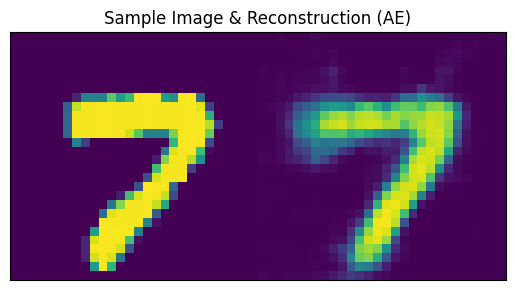

In [ ]:
# reconstruct (random) image from latent representation
index = np.random.randint(0, len(mnist_testset)-1) # generate random index
img = mnist_testset[index][0].unsqueeze(0).to(device) # original image
encoder.eval() # set encoder to evaluation mode
decoder.eval() # set encoder to evaluation mode
with torch.no_grad(): # no need to track the gradients in evaluation mode
    rec_img  = decoder(encoder(img)) # reconstructed image
result = np.hstack((img.cpu().squeeze(), rec_img.cpu().squeeze())) # stack original and reconstructed images
plt.grid(False) # hide grid
plt.tick_params(left=False, right=False, bottom=False,
                labelleft = False, labelbottom=False) # hide ticks and labels
plt.title('Sample Image & Reconstruction (AE)') # add title
plt.imshow(result); # show reconstructed image

4. Compare the reconstruction losses (MSE) of PCA and Autoencoder on the test data.

In [ ]:
print('PCA Model MSE : ', round(pca_mse, 3))
print('AE Model MSE  : ', round(test_epoch(encoder, decoder, device, test_loader, loss_fn).item(), 3))

PCA Model MSE :  0.056
AE Model MSE  :  0.038


---
##PCA v/s Autoencoder Model:

- It can be observed that the reconstruction loss (MSE) for principal component analysis (PCA) model is higher as compared to reconstruction loss (MSE) for autoencoder (AE) model. This is predominantly because PCA is a linear dimensionality reduction technique whereas autoencoder is a more powerful nonlinear dimensionality reduction technique, and the nature of this problem being complex, resulted in superior performance by AE model.

- It is to be noted however that AE model is not guaranteed to perform superior to PCA model under all circumstances. For example, AE model can overfit the data by learning the features to an extent that it works against the idea of the model altogether. Also, depending upon model architecture (e.g. fully-connected v/s convolutional AE models) the performance varies significantly.
---

5. Visualize the reduced results of PCA and Autoencoder.

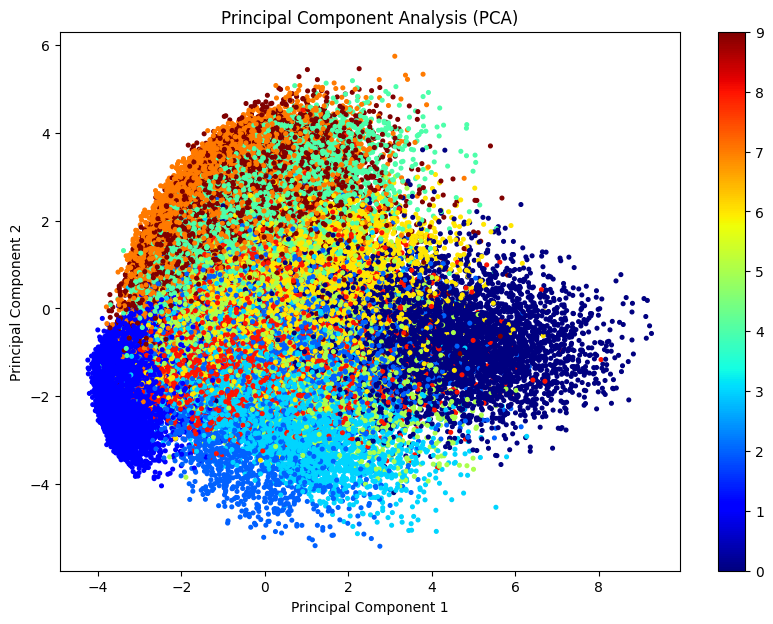

In [ ]:
plt.figure(figsize = (10,7)) # set figure size
plt.title('Principal Component Analysis (PCA)') # add title
plt.scatter(components[:, 0], # PC 1
            components[:, 1], # PC 2
            s=7, # marker (point) size
            c=np.asarray(mnist_trainset.targets), # colormap based on labels (targets)
            cmap=matplotlib.colormaps['jet']) # visualize latent representation
plt.colorbar() # add colorbar
plt.xlabel('Principal Component 1') # add x-axis label
plt.ylabel('Principal Component 2') # add y-axis label
plt.show() # show plot

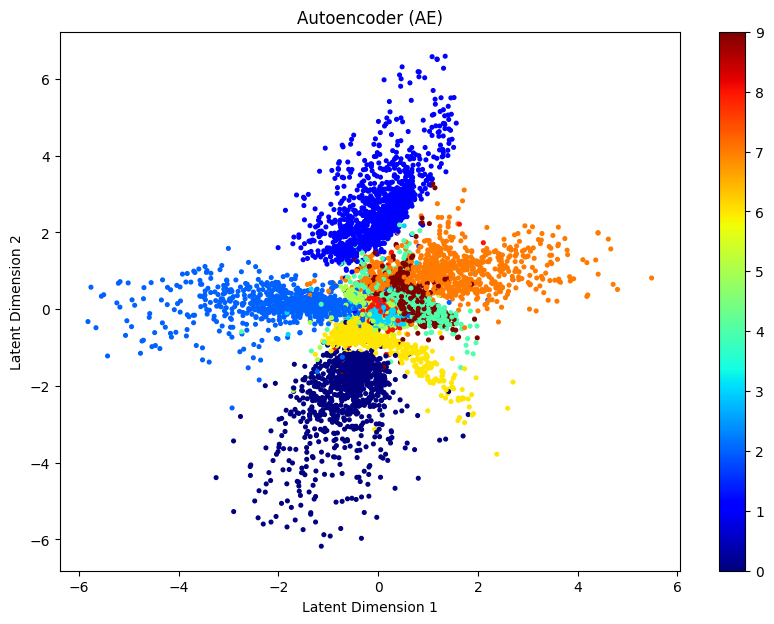

In [ ]:
encoded_samples = []
for sample in mnist_testset:
    image = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded  = encoder(image)
    # Append to list
    encoded = encoded.flatten().cpu().numpy()
    encoded_sample = {f"Latent Dimension {i+1}": code for i, code in enumerate(encoded)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples.plot.scatter(figsize = (10,7), # set figure size
                             x='Latent Dimension 1',
                             y='Latent Dimension 2',
                             s=7, # marker (point) size
                             c=np.asarray(mnist_testset.targets), # colormap based on labels (targets)
                             cmap=matplotlib.colormaps['jet']) # visualize latent representation
plt.title('Autoencoder (AE)') # add title
plt.xlabel('Latent Dimension 1') # add x-axis label
plt.ylabel('Latent Dimension 2') # add y-axis label
plt.show() # show plot

6. Analyse the pros and cons of each model.

---
##PCA Model:

####Pros:
- Simple architecture.
- Faster (computationally cheaper) to fit (train).
- No problem of overfitting.
- High analytical (algebraic) reasoning (explainability).
- Features are projections onto the orthogonal basis.
- Features are completely linearly uncorrelated with each other.
- Rich availability of algebraic tools for further analysis.

####Cons:
- Incapable of handling non-linear feature representations.
- Low interpretability of principal components.
- Trade-off between information loss and dimensionality reduction.
- Not robust against outliers.
- Sensitive to scale of the features.

---
##Autoencoder Model:

####Pros:
- Able to learn non-linear feature representations.
- Capable of dimensionality reduction of complex data.
- Applicable for image recognition, anomaly detection, information retrieval, popularity prediction, etc.

####Cons:
- Complex architecture.
- Slower (computationally expensive) to train.
- Prone to overfitting.
- Features may be correlated with each other.
- Low analytical reasoning (explainability).
- Low interpretability of latent feature representation.
- Trade-off between information loss and dimensionality reduction.
---

## Task 2: Generative Adversarial Networks
A generative adversarial network (GAN) is a class of machine learning frameworks designed by Ian Goodfellow and his colleagues in 2014. Two neural networks contest with each other in a game (in the form of a zero-sum game, where one agent's gain is another agent's loss). In this task, you need to create a GAN to generate specific class of figures for given condition (class). For example, give a label "3" (which represents Dress), you will use your network to generate a figure of Dress.

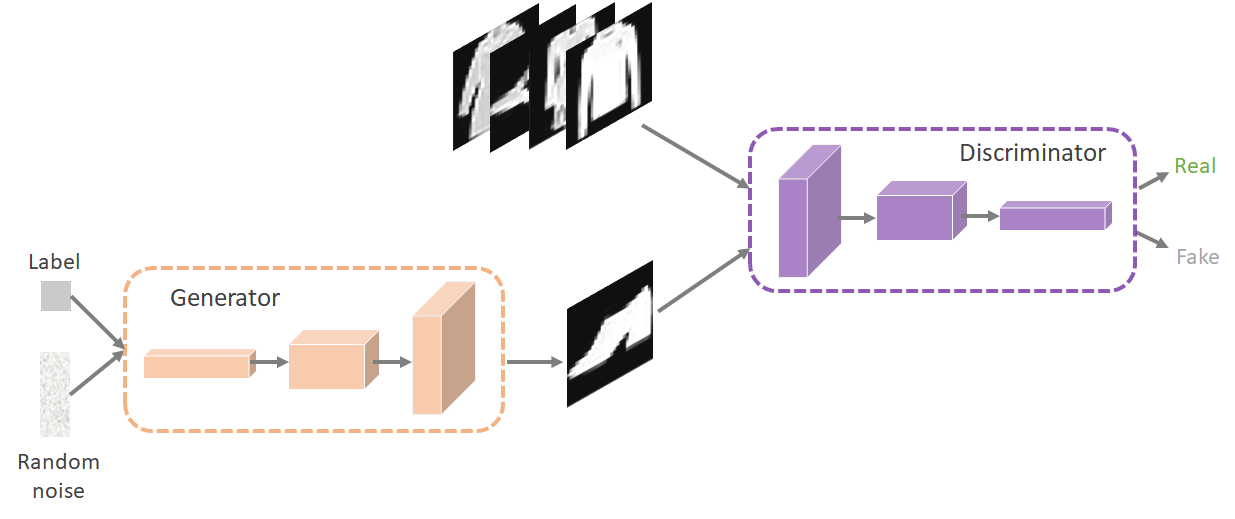



**Dataset**

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

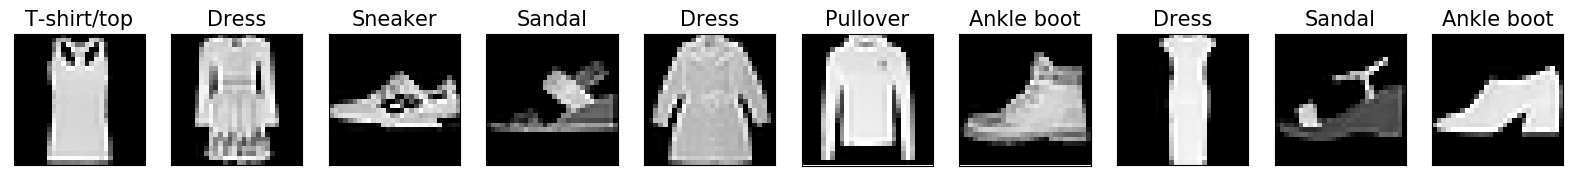

**Tasks**

1. Download the Fashion-MNIST dataset from Canvas and look into the data. Or you can directly load the Fashion-MNIST dataset using [Pytorch](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
    - The Fashion-MNIST dataset has 60000 training data. Each image is a 28x28 grayscale image, associated with a label from 10 classes. 
2. Create the custom dataset for your project.
3. Build a GAN model based on Pytorch and plot out the model.
4. Train your model and visualize the training history including the loss of Generator and Discriminator.
5. Plot the intermidiate results through the training procedure, e.g. after each 20 epochs in training plot a grid of generated results. (check this [resource](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) to figure out how to save the model and generate the intermediate results during the training)
6. Display final generated results for each of ten classes and discuss your results.

1. Load the Fashion-MNIST dataset.

In [ ]:
fashion_df = pd.read_csv(path+"Fashion_MNIST_Train.csv") # read data
fashion_df.head() # first few samples of data

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
images = fashion_df.iloc[:,1:].values.astype('uint8').reshape(-1, 28,28) # extract images
Image.fromarray(images[0]) # show sample image

2. Create the custom dataset for your project.

In [ ]:
class FashionMNIST(Dataset):
    def __init__(self, transform=None):
        self.transform = transform # declare transform
        fashion_df = pd.read_csv(path+"Fashion_MNIST_Train.csv") # read data
        self.labels = fashion_df.label.values # extract labels
        self.images = fashion_df.iloc[:, 1:].values.astype('uint8').reshape(-1, 28, 28) # extract images
    def __len__(self):
        return len(self.images) # length
    def __getitem__(self, idx):
        label = self.labels[idx]
        img = Image.fromarray(self.images[idx]) # item
        if self.transform:
            img = self.transform(img) # transformed item
        return img, label

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))
                                ]) # declare transform
dataset = FashionMNIST(transform=transform) # transform dataset
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)# data loader

3. Build a GAN model based on Pytorch and plot out the model.

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_embedding = nn.Embedding(10, 10) # label embedding
        self.model = nn.Sequential(
            nn.Linear(110, 256), # linear 1
            nn.LeakyReLU(0.2, inplace=True), # leaky relu activation
            nn.Linear(256, 512), # linear 2
            nn.LeakyReLU(0.2, inplace=True), # leaky relu activation
            nn.Linear(512, 1024), # linear 3
            nn.LeakyReLU(0.2, inplace=True), # leaky relu activation
            nn.Linear(1024, 784), # linear 4
            nn.Tanh() # tanh activation
        )
    def forward(self, z, labels):
        z = z.view(z.size(0), 100) # noise
        c = self.label_embedding(labels) # label embedding
        x = torch.cat([z, c], 1) # input
        y = self.model(x) # output
        return y.view(x.size(0), 28, 28)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_embedding = nn.Embedding(10, 10) # label embedding
        self.model = nn.Sequential(
            nn.Linear(794, 1024), # linear 1
            nn.LeakyReLU(0.2, inplace=True), # leaky relu activation
            nn.Dropout(0.3), # dropout 1
            nn.Linear(1024, 512), # linear 2
            nn.LeakyReLU(0.2, inplace=True), # leaky relu activation
            nn.Dropout(0.3), # dropout 2
            nn.Linear(512, 256), # linear 3
            nn.LeakyReLU(0.2, inplace=True), # leaky relu activation
            nn.Dropout(0.3), # dropout 3
            nn.Linear(256, 1), # linear 4
            nn.Sigmoid() # sigmoid activation
        )
    def forward(self, x, labels):
        x = x.view(x.size(0), 784) # image
        c = self.label_embedding(labels) # label embedding
        z = torch.cat([x, c], 1) # input
        y = self.model(z) # output
        return y.squeeze()

In [ ]:
generator = Generator().to(device) # move generator to selected device
discriminator = Discriminator().to(device) # move discriminator to selected device
criterion = nn.BCELoss() # loss function
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4) # optimizer for generator
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4) # optimizer for discriminator
print(generator) # print generator
print(discriminator) # print discriminator

Generator(
  (label_embedding): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=110, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
Discriminator(
  (label_embedding): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=794, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=

In [ ]:
for i, (images, labels) in enumerate(data_loader):
    real_images = Variable(images).to(device) # move image tensor to selected device
    labels = Variable(labels).to(device) # move label tensor to selected device
    batch_size = real_images.size(0) # extract batch size
    z = Variable(torch.randn(batch_size, 100)).to(device) # move tensor to selected device

images = generator(z, labels) # generate fake images using generator
validity = discriminator(images, labels) # validate fake images using discriminator

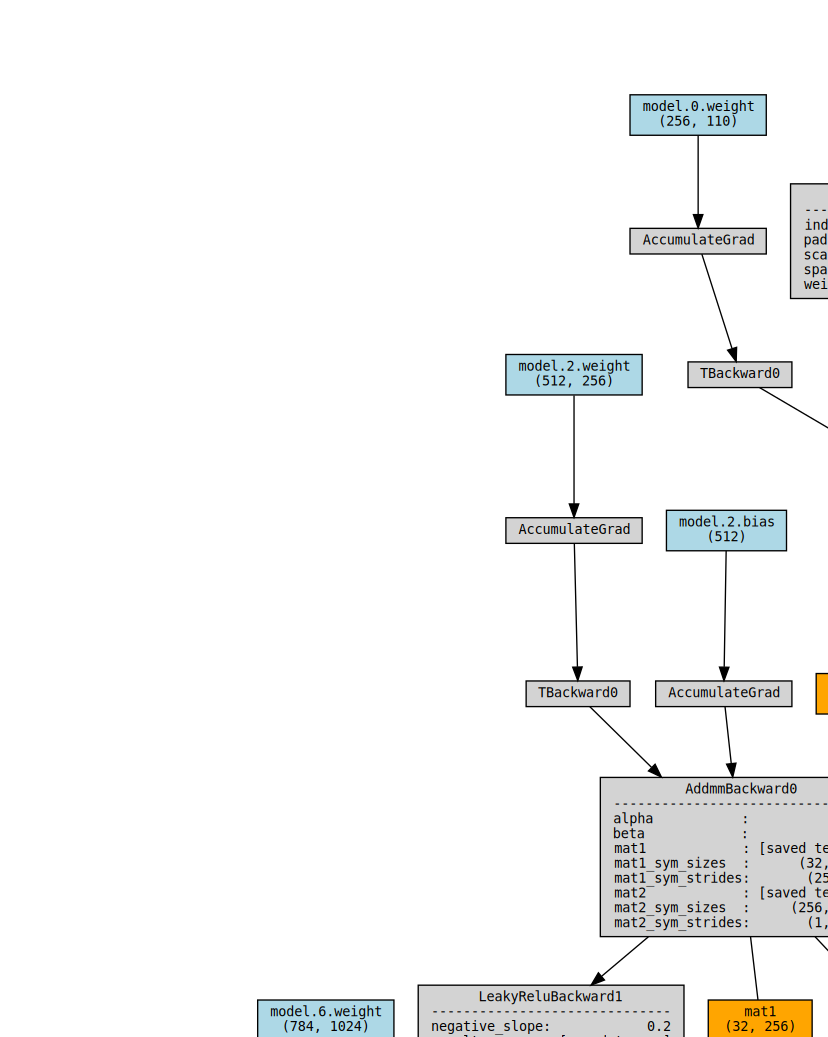

In [ ]:
generator_dot = make_dot(images, params=dict(generator.named_parameters()), show_attrs=True, show_saved=True) # create generator visualization
generator_dot.format = "pdf" # model visualization saving format
generator_dot.render(path + "Task2_Generator") # save model visualization
generator_dot # visualize model

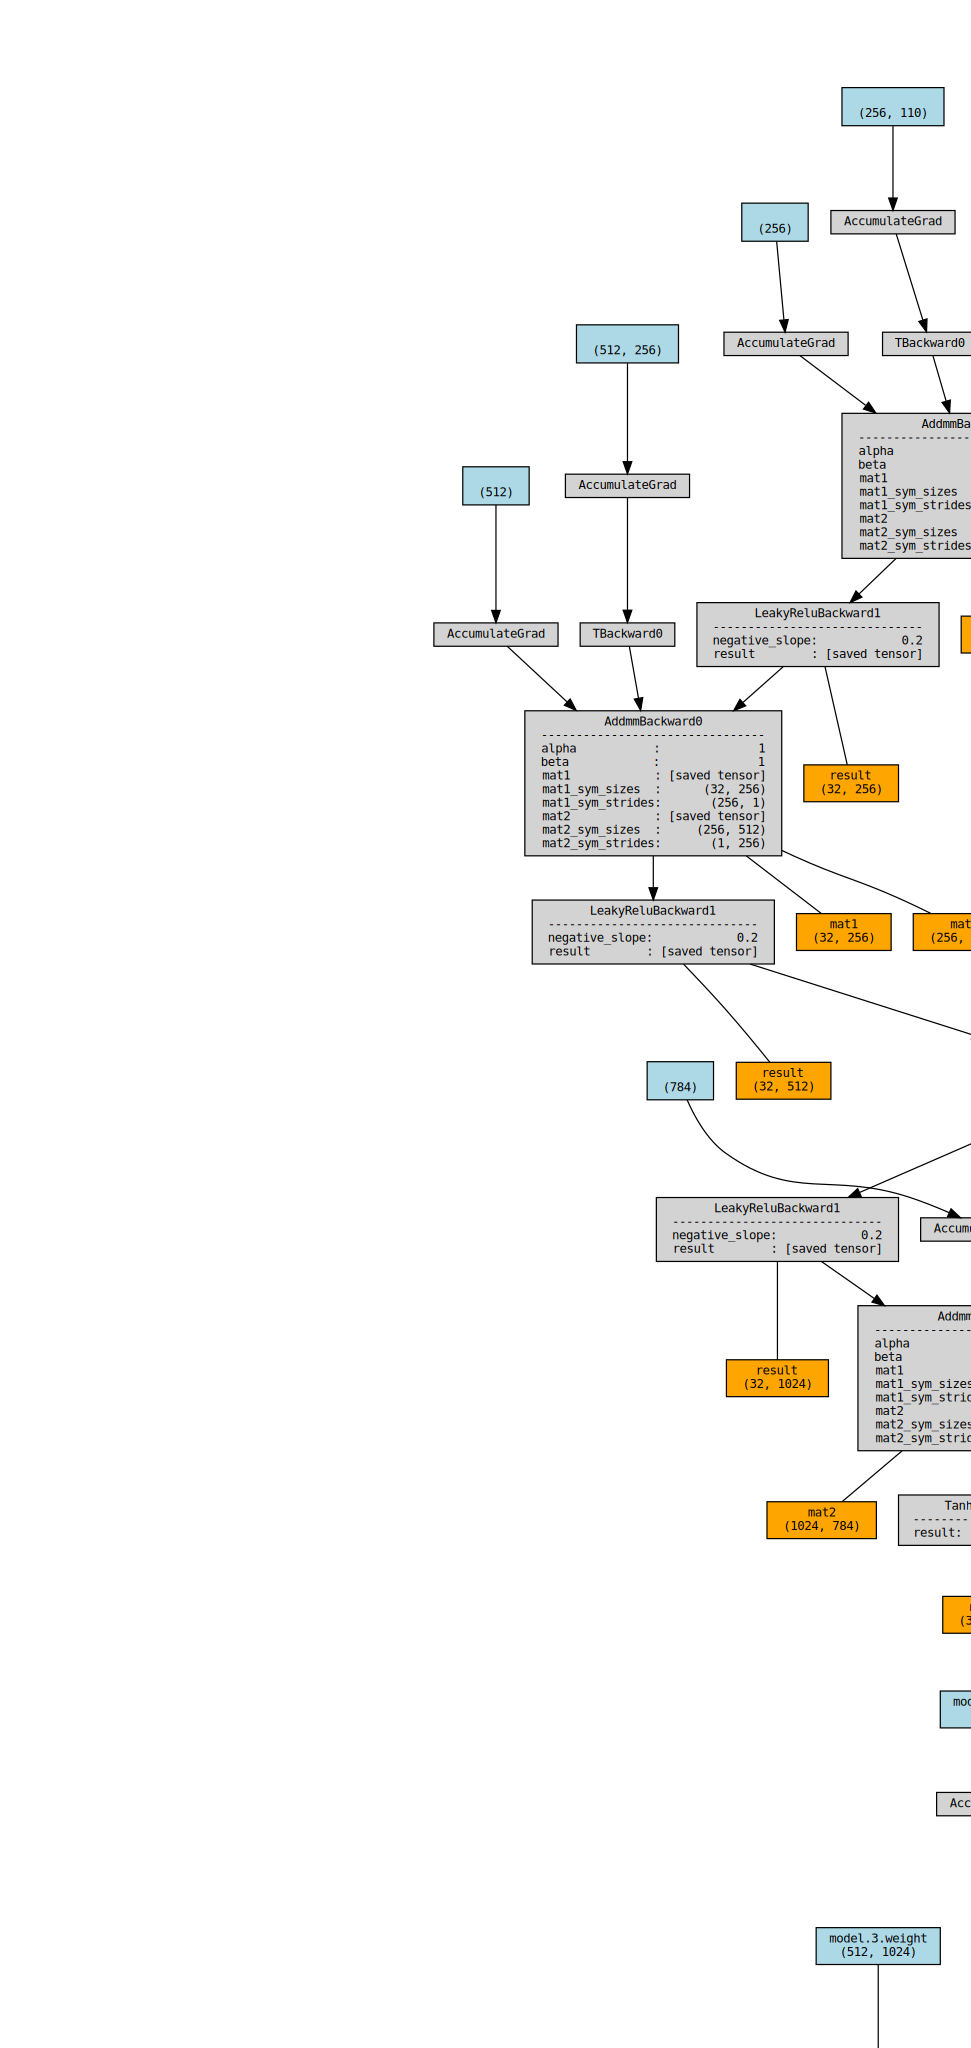

In [ ]:
discriminator_dot = make_dot(validity, params=dict(discriminator.named_parameters()), show_attrs=True, show_saved=True) # create discriminator visualization
discriminator_dot.format = "pdf" # model visualization saving format
discriminator_dot.render(path + "Task2_Discriminator") # save model visualization
discriminator_dot # visualize model

4. Train your model and visualize the training history including the loss of Generator and Discriminator.

In [ ]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad() # reset gradient
    z = Variable(torch.randn(batch_size, 100)).to(device) # move input tensor to selected device
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).to(device) # move labels tensor to selected device
    fake_images = generator(z, fake_labels) # generate fake images using generator
    validity = discriminator(fake_images, fake_labels) # validate fake images using discriminator
    '''
    Generator needs to generate images that can fool the discriminator, hence the discriminator
    should classify generator's output image as a real one (label: 1). Hence, generator's loss
    is binary cross entropy (BCE) loss between the discriminator's prediction and 1.
    '''
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).to(device)) # generator loss computation
    g_loss.backward() # generator backpropagation
    g_optimizer.step() # generator parameter update
    return g_loss.data

In [ ]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad() # reset gradient
    '''
    Discriminator's loss is comprised of two things:
    1) The real images should be classified as 1, hence a BCE between it's prediction for real images and 1
    2) Fake images should be classified as 0, hence a BCE between it's prediction for fake images and 0
    '''
    # real loss
    real_validity = discriminator(real_images, labels) # validate real images using discriminator
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).to(device)) # discriminator real loss computation
    # fake loss
    z = Variable(torch.randn(batch_size, 100)).to(device) # move input tensor to selected device
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).to(device) # move label tensor to selected device
    fake_images = generator(z, fake_labels) # generate fake images using generator
    fake_validity = discriminator(fake_images, fake_labels) # validate fake images using discriminator
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).to(device)) # discriminator real loss computation
    # net loss
    d_loss = real_loss + fake_loss # discriminator loss computation (add real and fake loss)
    d_loss.backward() # discriminator backpropagation
    d_optimizer.step() # discriminator parameter update
    return d_loss.data

5. Plot the intermidiate results through the training procedure.

Started Training!


Epoch: 1    Generator Loss: 4.8195    Discriminator Loss: 0.1872


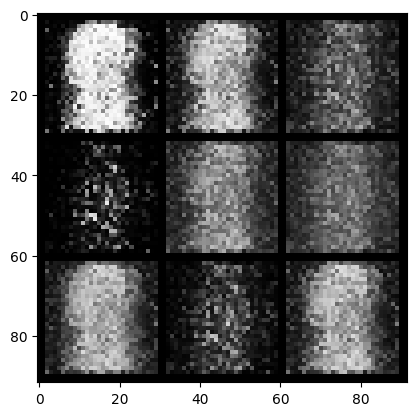

Epoch: 2    Generator Loss: 4.1272    Discriminator Loss: 0.2724


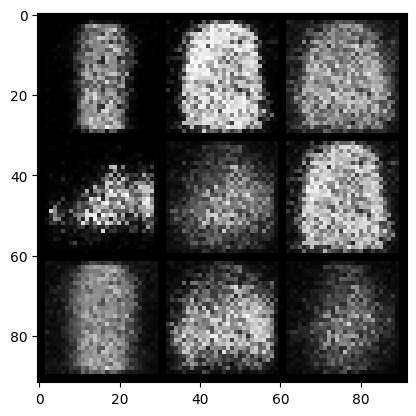

Epoch: 3    Generator Loss: 4.0764    Discriminator Loss: 0.3007


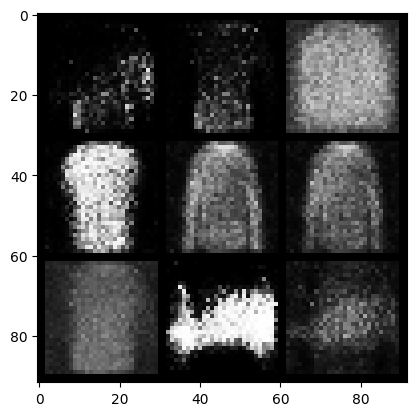

Epoch: 4    Generator Loss: 2.5055    Discriminator Loss: 0.3470


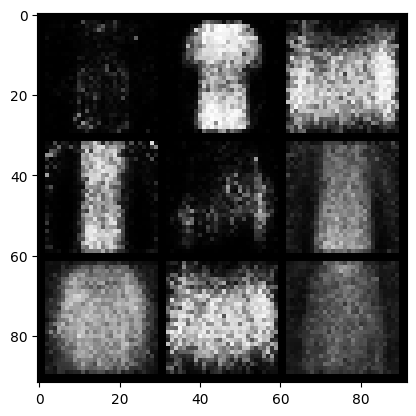

Epoch: 5    Generator Loss: 2.6534    Discriminator Loss: 0.2899


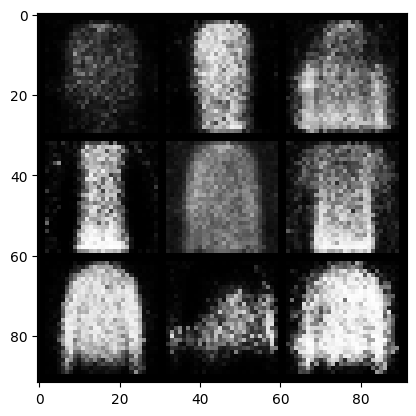

Epoch: 6    Generator Loss: 1.9900    Discriminator Loss: 0.6290


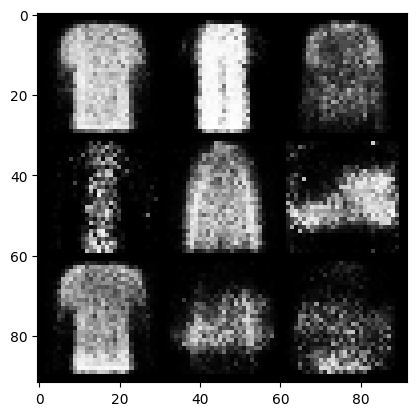

Epoch: 7    Generator Loss: 2.0613    Discriminator Loss: 0.6392


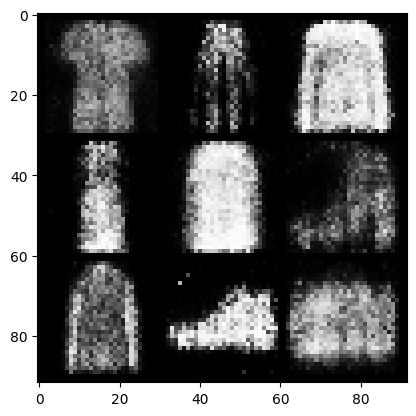

Epoch: 8    Generator Loss: 1.5460    Discriminator Loss: 1.0116


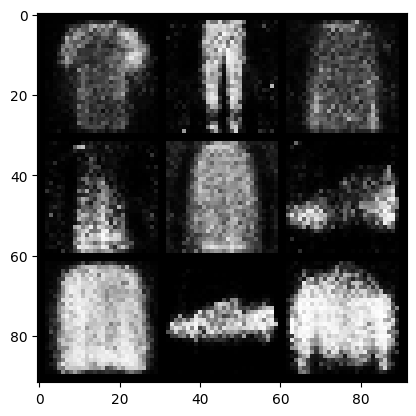

Epoch: 9    Generator Loss: 2.0866    Discriminator Loss: 0.9364


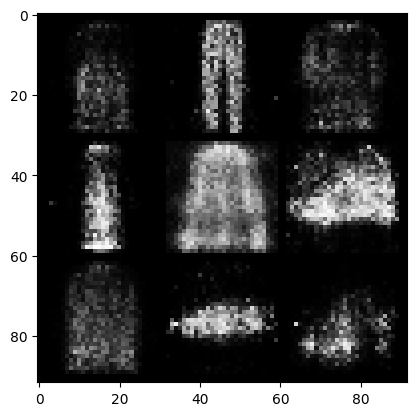

Epoch: 10    Generator Loss: 1.6267    Discriminator Loss: 0.9503


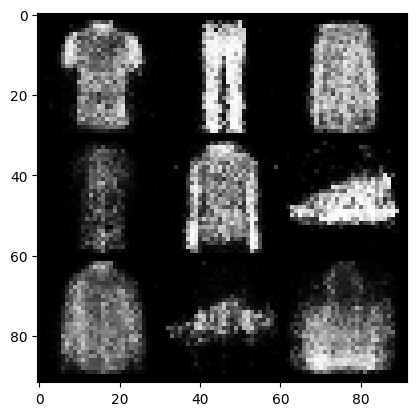

Epoch: 11    Generator Loss: 1.5524    Discriminator Loss: 0.8921


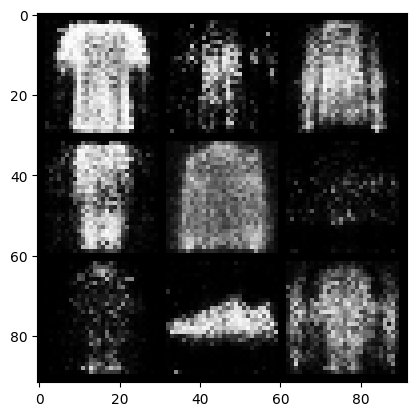

Epoch: 12    Generator Loss: 1.5961    Discriminator Loss: 0.8874


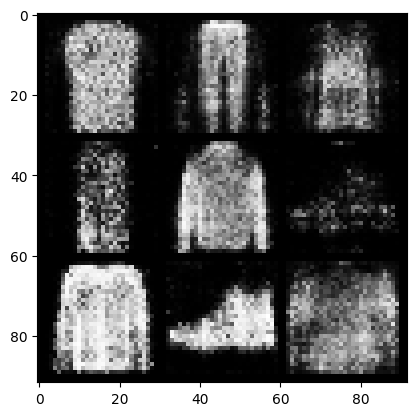

Epoch: 13    Generator Loss: 1.3552    Discriminator Loss: 1.0125


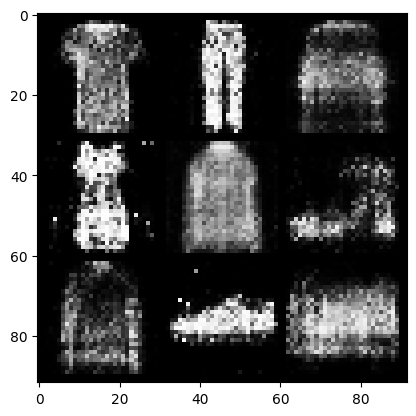

Epoch: 14    Generator Loss: 1.4015    Discriminator Loss: 0.7689


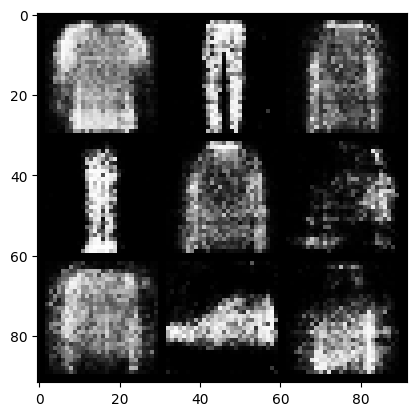

Epoch: 15    Generator Loss: 1.3851    Discriminator Loss: 1.0894


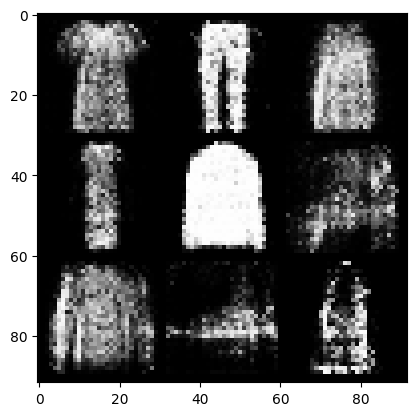

Epoch: 16    Generator Loss: 1.6692    Discriminator Loss: 1.1859


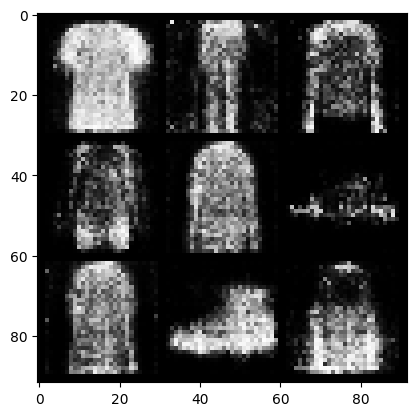

Epoch: 17    Generator Loss: 1.1958    Discriminator Loss: 1.2083


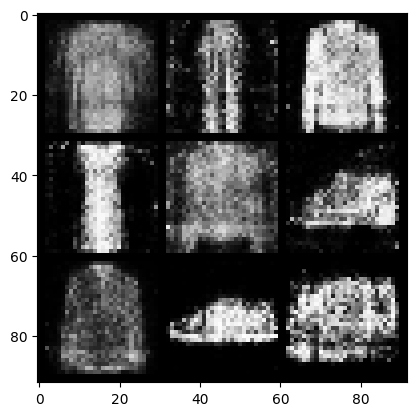

Epoch: 18    Generator Loss: 1.3238    Discriminator Loss: 0.9563


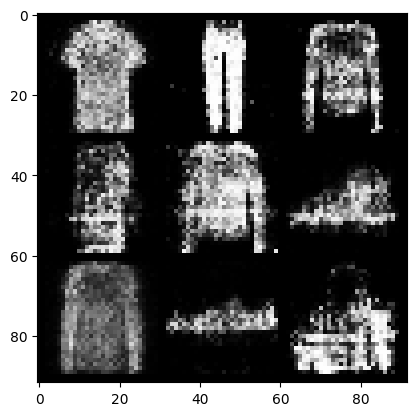

Epoch: 19    Generator Loss: 1.2603    Discriminator Loss: 0.7552


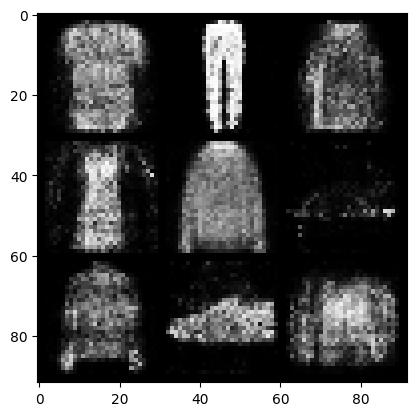

Epoch: 20    Generator Loss: 1.2330    Discriminator Loss: 0.7707


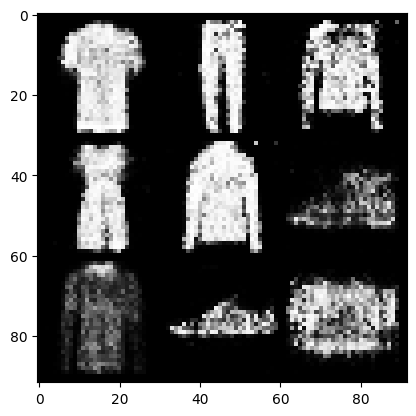

Epoch: 21    Generator Loss: 1.4285    Discriminator Loss: 0.8159


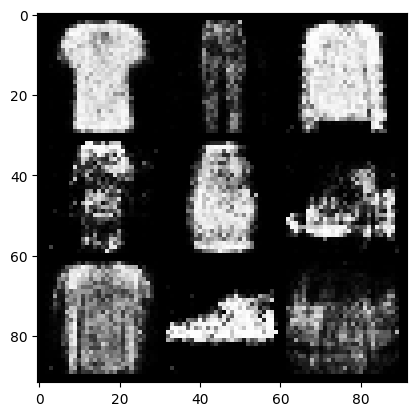

Epoch: 22    Generator Loss: 1.3839    Discriminator Loss: 0.9962


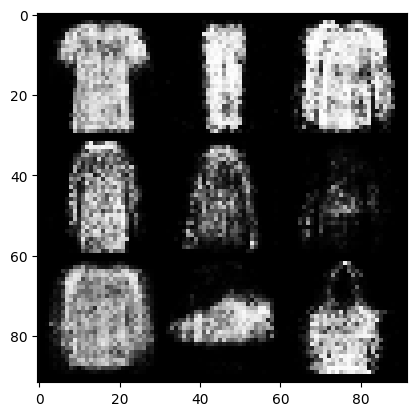

Epoch: 23    Generator Loss: 1.3119    Discriminator Loss: 1.2393


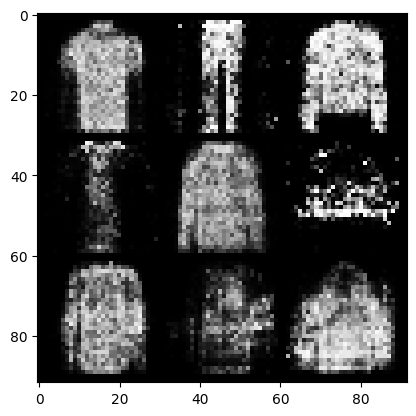

Epoch: 24    Generator Loss: 1.3859    Discriminator Loss: 1.0757


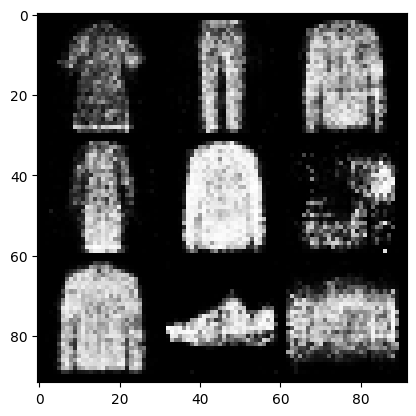

Epoch: 25    Generator Loss: 1.1642    Discriminator Loss: 1.0435


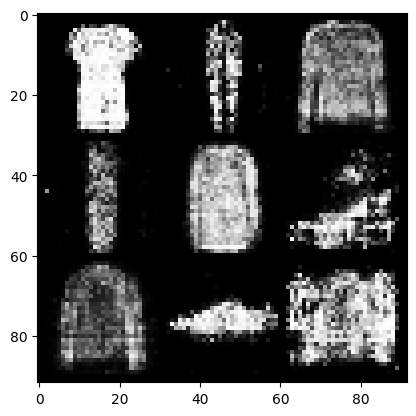

Epoch: 26    Generator Loss: 1.2426    Discriminator Loss: 1.0732


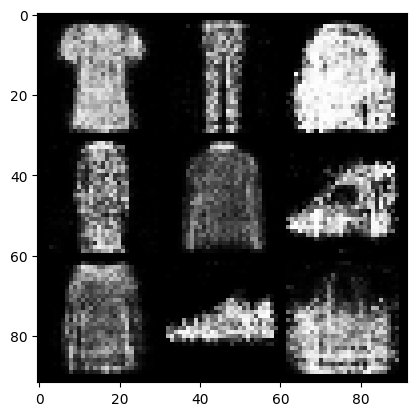

Epoch: 27    Generator Loss: 1.0796    Discriminator Loss: 1.2653


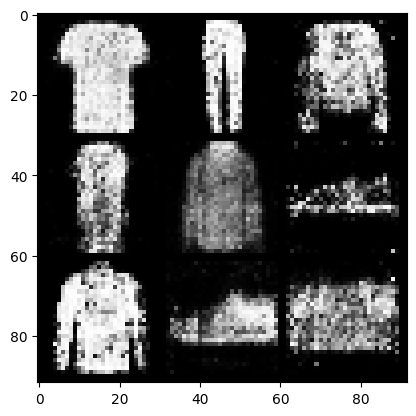

Epoch: 28    Generator Loss: 1.2519    Discriminator Loss: 0.9655


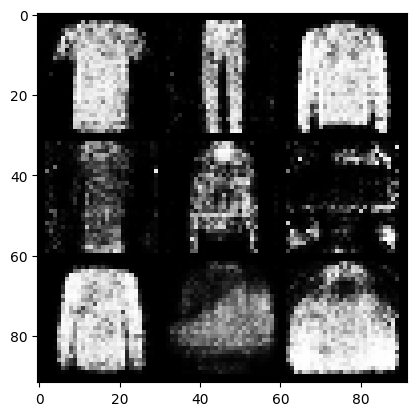

Epoch: 29    Generator Loss: 0.9901    Discriminator Loss: 0.9298


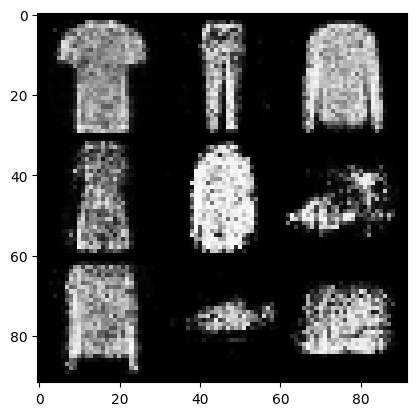

Epoch: 30    Generator Loss: 0.9659    Discriminator Loss: 0.9565


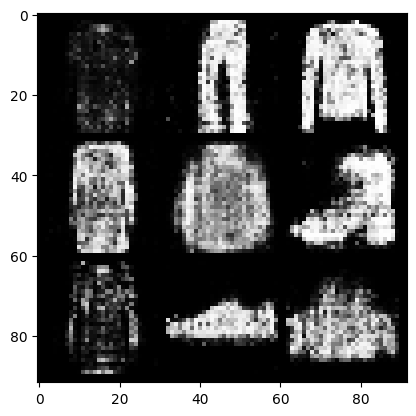

Epoch: 31    Generator Loss: 1.1862    Discriminator Loss: 1.0472


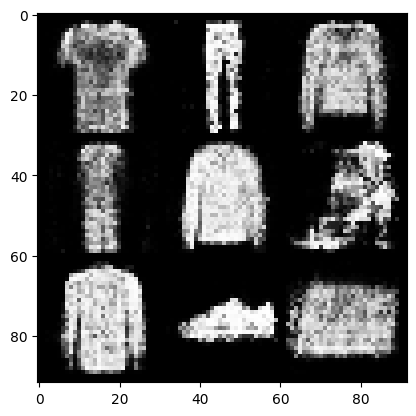

Epoch: 32    Generator Loss: 0.8956    Discriminator Loss: 1.1961


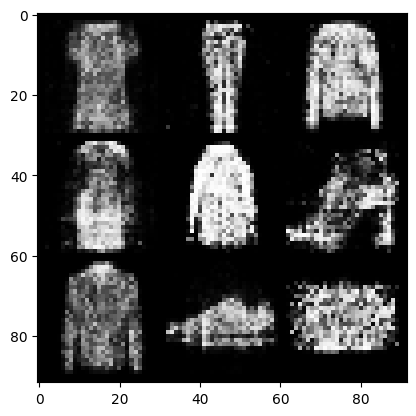

Epoch: 33    Generator Loss: 0.9755    Discriminator Loss: 1.0575


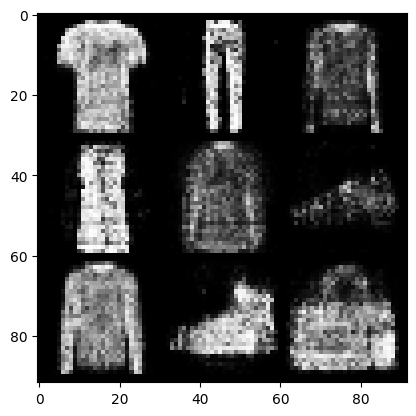

Epoch: 34    Generator Loss: 0.8389    Discriminator Loss: 1.3517


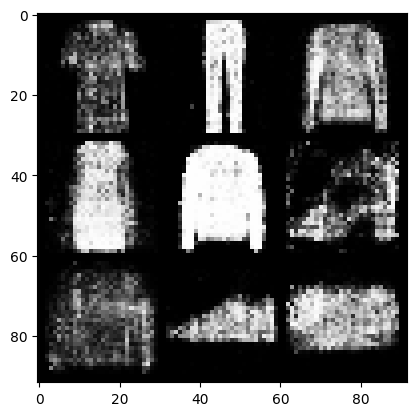

Epoch: 35    Generator Loss: 1.0482    Discriminator Loss: 1.0883


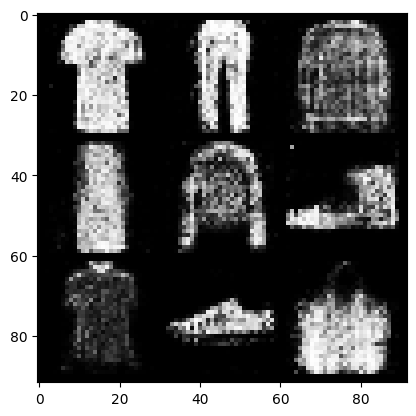

Epoch: 36    Generator Loss: 0.9793    Discriminator Loss: 1.2460


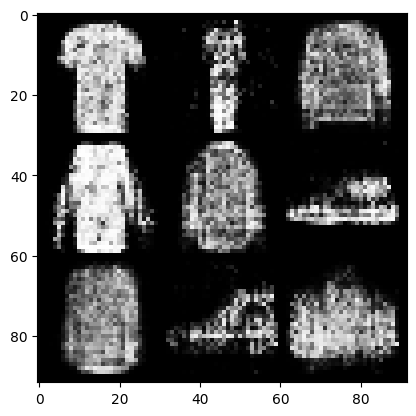



Finished Training!


In [ ]:
epochs = 36 # number of training epochs
g_losses = [] # history of generator losses
d_losses = [] # history of discriminator losses

print("Started Training!\n\n") # begin training

for epoch in range(epochs):
    for i, (images, labels) in enumerate(data_loader):
        real_images = Variable(images).to(device) # move image tensor to selected device
        labels = Variable(labels).to(device) # move label tensor to selected device
        batch_size = real_images.size(0) # extract batch size
        generator.train() # set generator to training mode
        d_loss = discriminator_train_step(batch_size, discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels) # compute discriminator loss
        g_loss = generator_train_step(batch_size, discriminator, generator,
                                      g_optimizer, criterion) # compute generator loss
        d_losses.append(d_loss.cpu()) # append discriminator loss
        g_losses.append(g_loss.cpu()) # append generator loss
    print("Epoch: {}    Generator Loss: {:.4f}    Discriminator Loss: {:.4f}".format(
          epoch+1, g_loss, d_loss)) # training log
    generator.eval() # set generator to evaluation mode
    z = Variable(torch.randn(9, 100)).to(device) # move input tensor to selected device
    labels = Variable(torch.LongTensor(np.arange(9))).to(device) # move label tensor to selected device
    sample_images = generator(z, labels).unsqueeze(1).data.cpu() # generate sample images
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy() # create grid of generated sample images
    plt.imshow(grid) # plot grid of generated sample images
    plt.show() # show plot

print("\n\nFinished Training!") # finish training

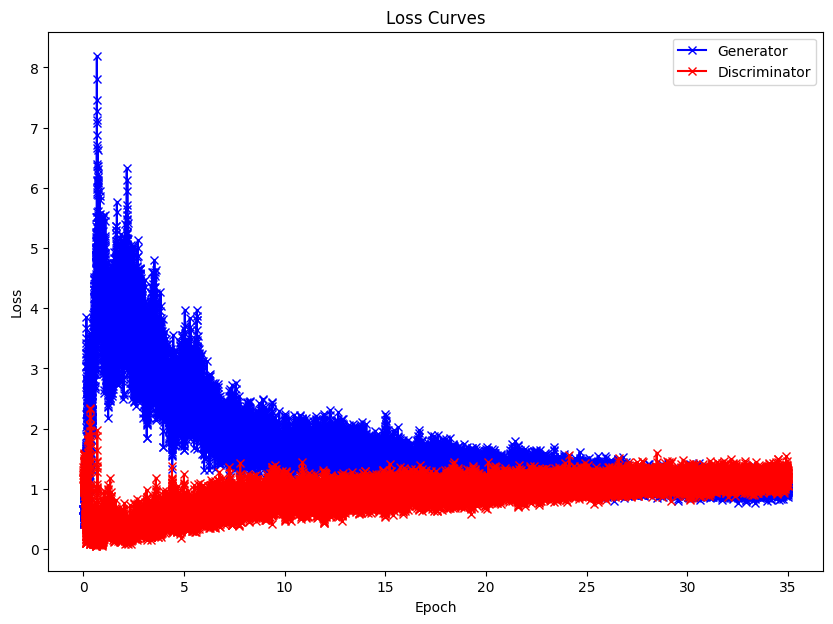

In [ ]:
# plot the loss history over all epochs
plt.figure(figsize=(10, 7)) # set figure size
plt.plot(np.linspace(0, 35, num=33768), g_losses, '-bx', label='Generator') # plot generator loss
plt.plot(np.linspace(0, 35, num=33768), d_losses, '-rx', label='Discriminator') # plot discriminator loss
plt.xlabel('Epoch') # add label for x-axis
plt.ylabel('Loss') # add label for y-axis
plt.legend() # add legend
plt.title('Loss Curves') # title
plt.show() # show plot

6. Display final generated results for each of ten classes and discuss your results.

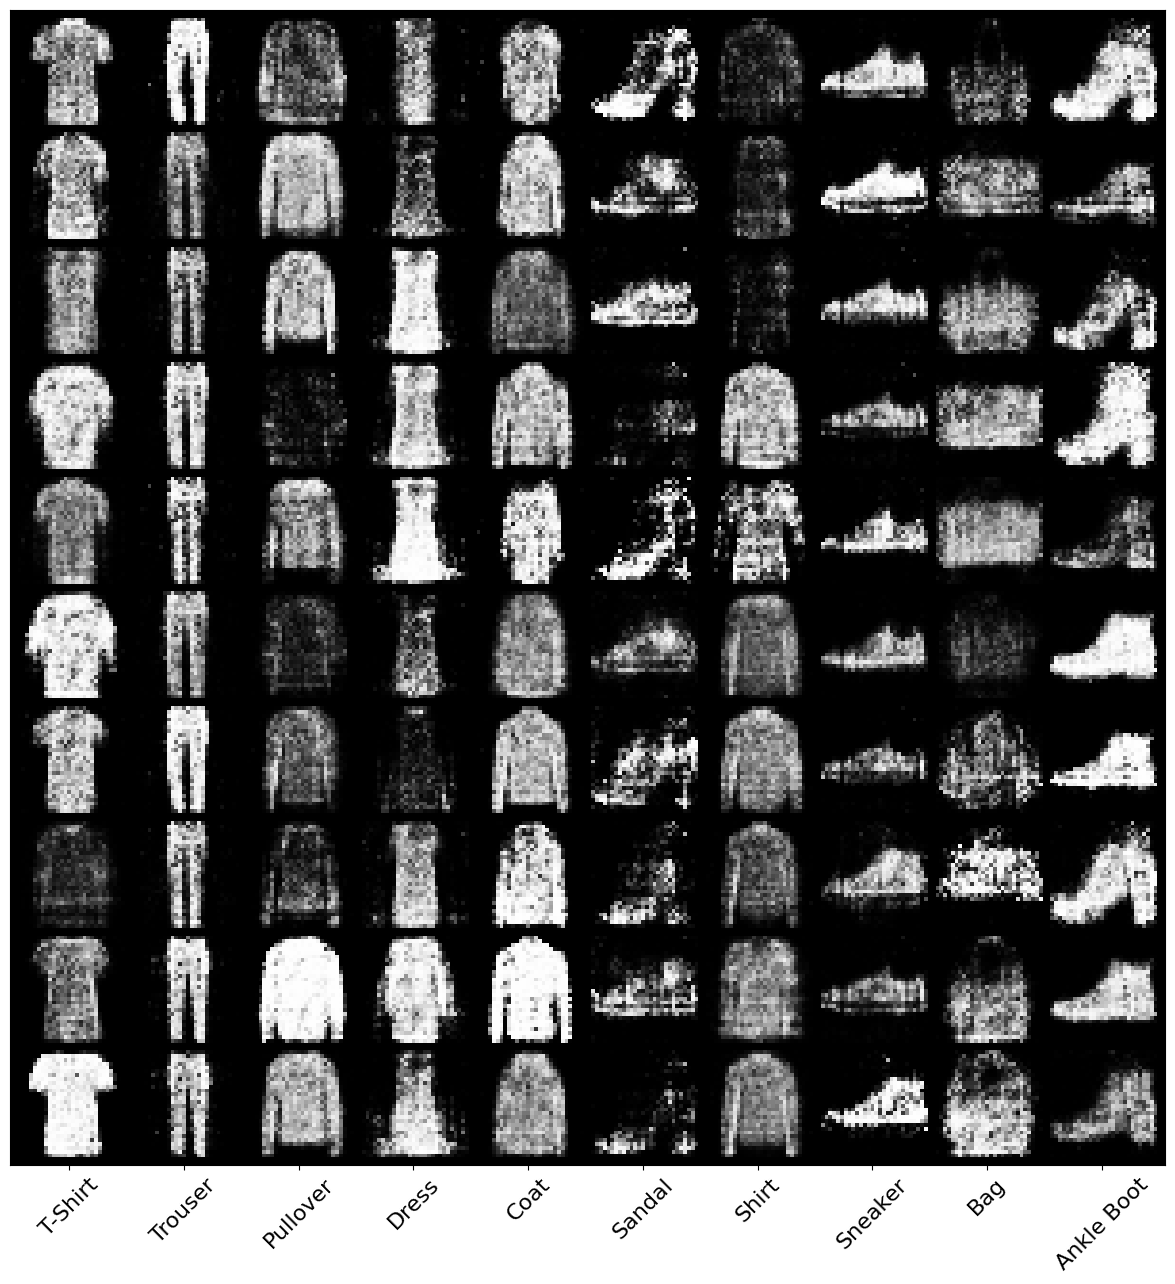

In [ ]:
z = Variable(torch.randn(100, 100)).to(device) # move input tensor to selected device
labels = Variable(torch.LongTensor([i for _ in range(10) for i in range(10)])).to(device) # move label tensor to selected device
generator.eval() # set generator to evaluation mode
sample_images = generator(z, labels).unsqueeze(1).data.cpu() # generate sample images
grid = make_grid(sample_images, nrow=10, normalize=True).permute(1,2,0).numpy() # create grid of generated sample images
fig, ax = plt.subplots(figsize=(15, 15)) # figure size
ax.imshow(grid) # show figure
_ = plt.xticks(np.arange(15, 300, 30), ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                                        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot'],
               rotation=45, fontsize=16) # x-axis tick labels
_ = plt.yticks([]) # y-axis tick labels

---
##Discussion of Results:
---
---
#### Model Training:

As observed from the general trend of loss terms (for both, generator as well as discriminator networks), the model has very well learned as intended.

Based on the quality of image generations with training progress, it is clearly evident that the generator is getting better and better at generating fake images closely resembling the real images (i.e. learning the true distribution of the training data) and thereby fooling the discriminator. However, based on the underlying game-theoretic framework of Generative Adversarial Networks (GANs), it can be observed that the discriminator is simultaneously getting better at differentiating (or discriminating) the fake images (generated by the generator network) from the real ones, which is further challanging the generator to come up with better (fake) images.

---
#### Model Convergence:

Although the random noise fed to the generator network as input seems to be the cause for the fluctuating (unstable) loss curves of GANs, this is but a significantly minor contributor - rather that is the whole point of GANs (to learn the true distribution of the training data by random sampling). The major cause for this issue lies issue in the fundamental arrangement or architecture of GANs - that is to say, since there are two networks (generator and discriminator) being trained at the same time, the problem of GAN convergence is one of the most challenging problems.

In this game-theoretic framework, the utopian situation where both networks stabilize and produce a consistent result is very difficult (near-impossible) to achieve. One explanation for this problem is that as the generator gets better with subsequent epochs, the discriminator performs worse because the discriminator can’t easily tell the difference between a real and a fake images.

If the generator succeeds all the time, the discriminator has a 50% accuracy. This poses a threat to the convergence of the GAN as a whole. Furthermore, as the discriminator’s feedback loses its meaning over subsequent epochs by giving outputs with equal probability, the generator may deteriorate its own quality if it continues to train on these junk training signals.

References:
- [Paper: "On Convergence and Stability of GANs"](https://arxiv.org/abs/1705.07215)
- [Article: "Why it is so hard to train Generative Adversarial Networks!"](https://jonathan-hui.medium.com/gan-why-it-is-so-hard-to-train-generative-advisory-networks-819a86b3750b)

---
#### Model Inference:
Upon model training, we are no longer interested in the discriminator model and as such, only the generator model is used in evaluation mode

$K$-fold (with $K=10$) inference of the generator model on input tensor of size 100x100 where the elements ($i$) are randomly sampled from a standard normal (Gaussian) distribution i.e. $i ∼ N(0,1)$ for 10 labels including `T-Shirt`, `Trouser`, `Pullover`, `Dress`, `Coat`, `Sandal`, `Shirt`, `Sneaker`, `Bag`, and `Ankle Boot` can be seen above.

It is clearly evident from the generated images, that the generator model has learned the true distribution of the training data and is therefore capable of repeatedly generating fake images corresponding to all the different fashion items (i.e. labels) closely resembling the corresponding real images from the Fashion-MNIST dataset.

---